Evraz AI Challenge
---

29-31 октября 2021 г

**Трек 1: Продуйте металл через Data Science**. 

Разработайте модель, прогнозирующую содержание углерода и температуру чугуна во время процесса продувки металла

https://hackathon.evraz.com/

**Исходные данные**

В рамках этой задачи вам будут даны данные о продувки чугуна в цехе:

- **produv** – Таблица содержит основные параметры продувки - мгновенный расход кислорода и положение (наклон) фурмы
- **lom** – Вместе с чугуном в фурму засыпают лом - это часть технологического процесса. Таблица содержит вес и тип ломов, использованных в каждой плавке
- **plavki** – Основная информация по плавке - характеристики плавки (марка металла, направление разливки) и оборудования
- **sip** – Сыпучие добавки, используемые в технологическом процессе
- **chronom** – хронометраж - время начала и конца различных операций во время плавки
- **chugun** – Химический состав и характеристики чугуна
- **gas** – Информация об анализе отходящих газов
- **target** – целевые значения


- [описание задачи](https://russianhackers.notion.site/1-Data-Science-4cc89ba42de1429bbac316f59bf07a3b)
- [атрибутный состав данных](https://russianhackers.notion.site/a685453e4fde41a098d9ad704d906e21?v=c482eaeb8f3143d58763b4b9008f1fec)


In [1]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Функции

In [2]:
symbols = (u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
           u"abvgdeejzijklmnoprstufhzcss_y_euaABVGDEEJZIJKLMNOPRSTUFHZCSS_Y_EUA")
tr = {ord(a):ord(b) for a, b in zip(*symbols)}

In [3]:
def feat_anal(series):
    """
    Параметры фичи
    """
    print('\n')
    print(f'feat name: {series.name}')
    print(f'min | max values = {series.min()} | {series.max()}')
    print(f'value range = {series.max() - series.min()}')
    print(f'No unique values = {series.nunique()}')
    print(f'axis 1 shape = {series.shape[0]}')
    print(f'sum of Nan = {series.isna().sum()}')
    
    
    
# feat_anal(sip_train["NPLV"])

# feat_anal(target_train["NPLV"])

# Загрузка данных

In [4]:
path = Path('../../../data/2021_evraz')

## chronom: хронометраж - время начала и конца различных операций во время плавки

- NPLV	- номер плавки
- TYPE_OPER	- тип операции
- NOP	- наименование операции
- VR_NACH	- время начала операции
- VR_KON	- время окончания операции
- O2	- количество кислорода, израсходованное на операцию

In [5]:
chronom_train = pd.read_csv(path.joinpath('chronom_train.csv'), index_col=0)
chronom_train['VR_NACH'] = chronom_train['VR_NACH'].apply(lambda x: pd.Timestamp(x))
chronom_train['VR_KON'] = chronom_train['VR_KON'].apply(lambda x: pd.Timestamp(x))
chronom_train = chronom_train.drop(chronom_train[chronom_train['VR_NACH'] < '2021'].index, axis=0)
chronom_train

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN
...,...,...,...,...,...,...
20943,512322,опер,Повалка,2021-04-26 18:31:26,2021-04-26 18:41:10,NaN
20944,512322,опер,Выпуск металла,2021-04-26 18:41:10,2021-04-26 18:47:40,NaN
20945,512322,опер,Отсечка шлака,2021-04-26 18:46:15,2021-04-26 18:46:15,NaN
20946,512322,опер,Прерыв. выпуска,2021-04-26 18:47:40,2021-04-26 18:48:40,NaN


In [6]:
chronom_train.iloc[0,-2]

Timestamp('2021-01-01 03:08:11')

In [7]:
chronom_train['VR_NACH'] < '2021'

35162    False
35163    False
35164    False
35165    False
35166    False
         ...  
20943    False
20944    False
20945    False
20946    False
20947    False
Name: VR_NACH, Length: 31991, dtype: bool

In [8]:
chronom_train[chronom_train['VR_NACH'] < '2021'].sort_values(by='VR_NACH')

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2


**Максимальная невалидная дата `2011-05-07`. Значит можно удалять всё что меньше 2020-го**

In [9]:
chronom_test = pd.read_csv(path.joinpath('chronom_test.csv'), index_col=0)
chronom_test['VR_NACH'] = chronom_test['VR_NACH'].apply(lambda x: pd.Timestamp(x))
chronom_test['VR_KON'] = chronom_test['VR_KON'].apply(lambda x: pd.Timestamp(x))
chronom_test = chronom_test.drop(chronom_test[chronom_test['VR_NACH'] < '2021'].index, axis=0)
chronom_test

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
1,512324,межпл.прост.,межпл. простой,2021-05-05 17:35:55,2021-05-05 17:41:21,NaN
2,512324,межпл.прост.,Осмотр конвертера,2021-05-05 17:36:07,2021-05-05 17:39:07,NaN
3,512324,межпл.прост.,Слив шлака,2021-05-05 17:39:07,2021-05-05 17:41:20,NaN
4,512324,опер,Завалка лома,2021-05-05 17:41:21,2021-05-05 17:43:16,NaN
5,512324,опер,Нагрев лома,2021-05-05 17:43:16,2021-05-05 17:49:21,NaN
...,...,...,...,...,...,...
7840,513374,опер,Завалка лома,2021-06-29 22:43:02,2021-06-29 22:43:54,NaN
7841,513374,опер,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,NaN
7842,513374,опер,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,1797.0
7843,513374,опер,Заливка чугуна,2021-06-29 22:50:07,2021-06-29 22:53:43,NaN


In [10]:
chronom_test.iloc[0,-2]

Timestamp('2021-05-05 17:41:21')

In [11]:
# количество дубликатов
chronom_train.duplicated(subset=['NPLV']).value_counts()

True     29928
False     2063
dtype: int64

In [12]:
# количество дубликатов
chronom_test.duplicated(subset=['NPLV']).value_counts()

True     6167
False     780
dtype: int64

In [13]:
# датафрейм дубликатов
ids = chronom_train["NPLV"]
chronom_train[ids.isin(ids[ids.duplicated()])].sort_values('NPLV')

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
33,510008,опер,Слив шлака,2021-01-01 03:51:10,2021-01-01 03:51:10,NaN
32,510008,опер,Прерыв. выпуска,2021-01-01 03:50:10,2021-01-01 03:51:10,NaN
31,510008,опер,Выпуск металла,2021-01-01 03:44:32,2021-01-01 03:50:10,NaN
30,510008,опер,Повалка,2021-01-01 03:37:55,2021-01-01 03:44:32,NaN
...,...,...,...,...,...,...
58737,512322,межпл.прост.,Осмотр конвертера,2021-04-26 17:23:48,2021-04-26 17:27:47,NaN
58736,512322,межпл.прост.,межпл. простой,2021-04-26 17:23:37,2021-04-26 17:28:00,NaN
20946,512322,опер,Прерыв. выпуска,2021-04-26 18:47:40,2021-04-26 18:48:40,NaN
20940,512322,опер,Нагрев лома,2021-04-26 18:08:46,2021-04-26 18:09:00,NaN


In [14]:
# датафрейм дубликатов
ids = chronom_test["NPLV"]
chronom_test[ids.isin(ids[ids.duplicated()])].sort_values('NPLV')

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
1,512324,межпл.прост.,межпл. простой,2021-05-05 17:35:55,2021-05-05 17:41:21,NaN
2,512324,межпл.прост.,Осмотр конвертера,2021-05-05 17:36:07,2021-05-05 17:39:07,NaN
3,512324,межпл.прост.,Слив шлака,2021-05-05 17:39:07,2021-05-05 17:41:20,NaN
4,512324,опер,Завалка лома,2021-05-05 17:41:21,2021-05-05 17:43:16,NaN
5,512324,опер,Нагрев лома,2021-05-05 17:43:16,2021-05-05 17:49:21,NaN
...,...,...,...,...,...,...
7838,513374,межпл.прост.,Слив шлака,2021-06-29 22:33:42,2021-06-29 22:38:59,NaN
7837,513374,межпл.прост.,Наведение гарнисажа,2021-06-29 22:29:57,2021-06-29 22:33:42,NaN
7836,513374,межпл.прост.,межпл. простой,2021-06-29 22:29:44,2021-06-29 22:43:02,NaN
7839,513374,межпл.прост.,Вхождение в гр.МНЛЗ,2021-06-29 22:38:59,2021-06-29 22:43:06,NaN


In [15]:
print("ID уникален? ", chronom_test["NPLV"].is_unique)
print("Есть ли дубли в строках?", chronom_test["NPLV"].duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((chronom_test["NPLV"].isnull().sum() > 0).sum()/len(chronom_test["NPLV"])*100))

ID уникален?  False
Есть ли дубли в строках? 6167
Сколько процент признаков могут принимать null-значениями? 0%


In [16]:
chronom_train["NPLV"].min(), chronom_train["NPLV"].max()

(510008, 512322)

In [17]:
chronom_test["NPLV"].min(), chronom_test["NPLV"].max()

(512324, 513374)

## chugun: химический состав и характеристики чугуна

- NPLV	- номер плавки
- VES	- вес чугуна
- T	- температура чугуна
- SI	- SI вчугуне
- MN	- MN в чугуне
- S	- S в чугуне
- P	 - P в чугуне
- CR	- CR в чугуне
- NI	- NI в чугуне
- CU	- CU в чугуне

In [18]:
chugun_train = pd.read_csv(path.joinpath('chugun_train.csv'))
chugun_train['DATA_ZAMERA'] = chugun_train['DATA_ZAMERA'].apply(lambda x: pd.Timestamp(x))
chugun_train

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40
3,510011,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57
4,510012,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,0.01,0.02,0.081,0.060,2021-04-26 12:53:40
2059,512319,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,0.01,0.02,0.079,0.081,2021-04-26 14:21:57
2060,512320,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,0.01,0.03,0.086,0.066,2021-04-26 14:33:29
2061,512321,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,0.01,0.03,0.076,0.060,2021-04-26 15:50:53


In [19]:
chugun_train[chugun_train['DATA_ZAMERA'] < '2021']

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA


In [20]:
chugun_train.iloc[0,-1]

Timestamp('2021-01-01 03:15:03')

In [21]:
chugun_test = pd.read_csv(path.joinpath('chugun_test.csv'))
chugun_test['DATA_ZAMERA'] = chugun_test['DATA_ZAMERA'].apply(lambda x: pd.Timestamp(x))
chugun_test

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,0.048,0.030,2021-05-05 17:22:54
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,0.050,0.024,2021-05-05 20:00:30
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-05 22:29:21
3,512331,266700.0,1383.0,0.54,0.39,0.028,0.115,0.02,0.01,0.03,0.059,0.042,2021-05-06 01:58:11
4,512333,267400.0,1387.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-06 05:27:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,513369,280800.0,1324.0,0.35,0.29,0.035,0.096,0.01,0.01,0.02,0.080,0.062,2021-06-29 16:51:30
776,513370,280600.0,1389.0,0.39,0.31,0.024,0.097,0.01,0.01,0.02,0.093,0.074,2021-06-29 17:35:57
777,513371,279700.0,1332.0,0.30,0.27,0.031,0.099,0.01,0.01,0.02,0.066,0.036,2021-06-29 18:52:34
778,513372,279700.0,1378.0,0.43,0.33,0.026,0.113,0.01,0.01,0.02,0.095,0.070,2021-06-29 19:42:11


In [22]:
chugun_test[chugun_test['DATA_ZAMERA'] < '2021']

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA


In [23]:
chugun_test.iloc[0,-1]

Timestamp('2021-05-05 17:22:54')

## gas: информация об анализе отходящих газов

- O2_pressure -	Давление кислорода	Фактически этот признак относится к  параметрам продувки
- T фурмы 2 -	Температура 2-ой фурмы	
- T фурмы 1 -	Температура 1-ой фурмы	В каждый момент времени активна только одна фурма, поэтому ее температура больше
- AR -	доля AR в отх. газах 	
- CO -	доля CO в отх. газах 	
- CO2 -	доля CO2 в отх. газах 	
- H2 -	доля H2 в отх. газах 	
- N2 -	доля N2 в отх. газах 	
- O2 -	доля O2 в отх. газах 	
- T -	температура отходящих газов	
- V -	объем выходящих газов	
- NPLV -	номер плавки	
- Time -	дата и время замера хим. состава отходящих газов. Информация об анализе отходящих газов

In [24]:
gas_train = pd.read_csv(path.joinpath('gas_train.csv'))
gas_train['Time'] = gas_train['Time'].apply(lambda x: pd.Timestamp(x))
gas_train

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,9.229025e-03,0.893243,0.000000,0.000000,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,8.390023e-03,0.892948,0.000000,0.000000,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,7.551021e-03,0.892653,0.000000,0.000000,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,6.712018e-03,0.892358,0.000000,0.000000,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,5.873016e-03,0.892063,0.000000,0.000000,13.093172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468013,512322,2021-04-26 18:48:35.437,207386.734375,118.402779,1.890000,97.220001,0.090000,0.050000,0.000000e+00,0.750000,23.900463,27.054343,14.424190
6468014,512322,2021-04-26 18:48:36.437,207051.609375,118.402779,2.710000,96.410004,0.080000,0.040000,0.000000e+00,0.770000,23.900463,27.054342,14.424190
6468015,512322,2021-04-26 18:48:37.437,207163.375000,118.402779,3.770000,95.349998,0.090000,0.030000,0.000000e+00,0.770000,23.900463,27.054341,14.438658
6468016,512322,2021-04-26 18:48:38.437,206827.906250,118.750000,3.400000,95.720001,0.090000,0.040000,0.000000e+00,0.750000,23.900463,27.054340,14.445890


In [25]:
gas_train[gas_train['NPLV'] == 510008]

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,0.006712,0.892358,0.0,0.0,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,0.005873,0.892063,0.0,0.0,13.093172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,510008,2021-01-01 03:51:06.437,218369.359375,131.944443,9.916870,78.370371,0.010074,10.185237,0.550623,0.973858,0.0,0.0,13.389757
2556,510008,2021-01-01 03:51:07.437,219426.875000,131.944443,9.929288,78.373759,0.010222,10.170386,0.549763,0.973769,0.0,0.0,13.389757
2557,510008,2021-01-01 03:51:08.437,219637.750000,131.944443,9.941707,78.377146,0.010370,10.155534,0.548902,0.973680,0.0,0.0,13.389757
2558,510008,2021-01-01 03:51:09.437,219321.343750,131.944443,9.954125,78.380534,0.010519,10.140683,0.548042,0.973591,0.0,0.0,13.389757


In [26]:
gas_train[gas_train['Time'] < '2021']

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure


In [27]:
gas_train.iloc[0,1]

Timestamp('2021-01-01 03:08:11.437000')

In [28]:
gas_test = pd.read_csv(path.joinpath('gas_test.csv'))
gas_test['Time'] = gas_test['Time'].apply(lambda x: pd.Timestamp(x))
gas_test

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,512324,2021-05-05 17:41:21.437,213979.046875,137.326396,18.671576,79.388503,0.153247,0.591429,0.216998,0.980324,26.244215,26.673637,16.124132
1,512324,2021-05-05 17:41:22.437,214303.343750,137.413201,18.678876,79.386573,0.153680,0.585952,0.216933,0.980043,26.244215,26.673768,16.124132
2,512324,2021-05-05 17:41:23.437,214842.750000,137.500007,18.686176,79.384642,0.154113,0.580476,0.216868,0.979762,26.244215,26.673900,16.124132
3,512324,2021-05-05 17:41:24.437,214842.750000,137.586812,18.693477,79.382712,0.154545,0.575000,0.216803,0.979482,26.244215,26.674031,16.124132
4,512324,2021-05-05 17:41:25.437,215273.281250,137.673618,18.700777,79.380781,0.154978,0.569524,0.216739,0.979201,26.244215,26.674163,16.124132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515863,513374,2021-06-29 23:29:03.437,232936.171875,141.319443,5.410000,81.769997,0.050000,11.600000,0.000000,1.160000,30.005785,30.295139,16.059027
2515864,513374,2021-06-29 23:29:04.437,232737.328125,141.319443,5.410000,81.769997,0.050000,11.600000,0.000000,1.160000,30.005785,30.295139,16.059027
2515865,513374,2021-06-29 23:29:05.437,232239.515625,142.013885,5.410000,81.769997,0.050000,11.600000,0.000000,1.160000,30.005785,30.295139,16.066261
2515866,513374,2021-06-29 23:29:06.437,232139.796875,142.361115,5.410000,81.769997,0.050000,11.600000,0.000000,1.160000,30.005785,30.295139,16.066261


In [29]:
gas_test[gas_test['Time'] < '2021']

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure


In [30]:
gas_test.iloc[0,1]

Timestamp('2021-05-05 17:41:21.437000')

## lom: вес и тип ломов в  плавке

Вместе с чугуном в фурму засыпают лом - это часть технологического процесса. Таблица содержит вес и тип ломов, использованных в каждой плавке

- NPLV	- номер плавки
- VDL	- код лома
- NML	- наименование лома
- VES	- вес лома

In [31]:
lom_train = pd.read_csv(path.joinpath('lom_train.csv'))
lom_train

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000
3,510009,4,К,49800
4,510009,8,О,22800
...,...,...,...,...
6371,512321,8,О,4200
6372,512321,13,КП,3000
6373,512322,4,К,66700
6374,512322,13,КП,6000


In [32]:
lom_test = pd.read_csv(path.joinpath('lom_test.csv'))
lom_test

,NPLV,VDL,NML,VES
0,512324,4,К,26040
1,512324,8,О,17660
2,512324,13,КП,2000
3,512327,8,О,10600
4,512327,23,ЛЧ,8000
...,...,...,...,...
2627,513372,48,У2КШ,500
2628,513374,4,К,54400
2629,513374,13,КП,7000
2630,513374,8,О,9100


## plavki: характеристики плавки (марка металла, направление разливки) и оборудования

Основная информация по плавке - характеристики плавки (марка металла, направление разливки) и оборудования

- NPLV -	номер плавки
- plavka_VR_NACH -	время начала плавки
- plavka_VR_KON -	время окончания плавки
- plavka_NMZ -	марка заданная 
- plavka_NAPR_ZAD -	направление разливки
- plavka_STFUT -	стойкость футеровки конвертера
- plavka_TIPE_FUR -	тип фурмы
- plavka_ST_FURM -	стойкость фурмы
- plavka_TIPE_GO -L	тип головки фурмы
- plavka_ST_GOL -	стойкость головки фурмы

In [33]:
plavki_train = pd.read_csv(path.joinpath('plavki_train.csv'))
plavki_train['plavka_VR_NACH'] = plavki_train['plavka_VR_NACH'].apply(lambda x: pd.Timestamp(x))
plavki_train['plavka_VR_KON'] = plavki_train['plavka_VR_KON'].apply(lambda x: pd.Timestamp(x))
plavki_train

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
...,...,...,...,...,...,...,...,...,...,...
2132,512318,2021-04-26 13:04:26,2021-04-26 13:55:50,C071TM.z01/ЭТ,МНЛС,3281,коническая,22,5 сопловая,56
2133,512319,2021-04-26 14:10:20,2021-04-26 15:14:23,C071TM.z01/ЭТ,МНЛС,3282,коническая,23,5 сопловая,57
2134,512320,2021-04-26 15:21:37,2021-04-26 16:16:42,40Х.1,МНЛЗ,3283,коническая,24,5 сопловая,58
2135,512321,2021-04-26 16:22:37,2021-04-26 17:23:37,40Х.1,МНЛЗ,3284,коническая,25,5 сопловая,59


In [34]:
plavki_train[plavki_train['plavka_VR_NACH'] < '2021']

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL


In [35]:
plavki_train.iloc[0,1], plavki_train.iloc[0,2]

(Timestamp('2021-01-01 03:08:11'), Timestamp('2021-01-01 03:51:10'))

In [36]:
plavki_test = pd.read_csv(path.joinpath('plavki_test.csv'))
plavki_test['plavka_VR_NACH'] = plavki_test['plavka_VR_NACH'].apply(lambda x: pd.Timestamp(x))
plavki_test['plavka_VR_KON'] = plavki_test['plavka_VR_KON'].apply(lambda x: pd.Timestamp(x))
plavki_test

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,512324,2021-05-05 17:41:21,2021-05-05 18:46:07,Ст3пс/Э,Изл,2,цилиндрическая,2,4-сопл х54,2
1,512327,2021-05-05 21:07:01,2021-05-05 22:02:26,C121TM/ЭТ,МНЛС,5,цилиндрическая,5,4-сопл х54,5
2,512328,2021-05-05 22:03:12,2021-05-05 23:39:32,Ст3пс/Э,Изл,6,цилиндрическая,6,4-сопл х54,6
3,512331,2021-05-06 02:21:46,2021-05-06 03:49:18,25Г2С,Изл,9,цилиндрическая,9,4-сопл х54,9
4,512333,2021-05-06 05:22:03,2021-05-06 06:25:51,C091TM.z01/ЭТ,МНЛС,11,цилиндрическая,11,4-сопл х54,11
...,...,...,...,...,...,...,...,...,...,...
775,513369,2021-06-29 17:08:33,2021-06-29 17:55:50,Ст3сп/Т,МНЛЗ,1047,цилиндрическая,2,601-5,2
776,513370,2021-06-29 18:03:00,2021-06-29 18:49:50,Ст3сп/Т,МНЛЗ,1048,цилиндрическая,3,601-5,3
777,513371,2021-06-29 18:55:21,2021-06-29 19:53:39,Ст3сп/Т,МНЛЗ,1049,цилиндрическая,4,601-5,4
778,513372,2021-06-29 20:18:40,2021-06-29 20:59:18,Ст3сп/Т,МНЛЗ,1050,цилиндрическая,5,601-5,5


In [37]:
plavki_test[plavki_test['plavka_VR_NACH'] < '2021']

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL


In [38]:
plavki_test.iloc[0,1], plavki_test.iloc[0,2]

(Timestamp('2021-05-05 17:41:21'), Timestamp('2021-05-05 18:46:07'))

## produv: параметры продувки - мгновенный расход кислорода и положение (наклон) фурмы

Таблица содержит основные параметры продувки - мгновенный расход кислорода и положение (наклон) фурмы

- NPLV	- номер плавки
- SEC	- время измерения
- RAS	- расход кислорода на продувку
- POL	- положение фурмы для продувки

In [39]:
produv_train = pd.read_csv(path.joinpath('produv_train.csv'))
produv_train['SEC'] = produv_train['SEC'].apply(lambda x: pd.Timestamp(x))
produv_train

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.000000,3.920000
1,510008,2021-01-01 03:18:28,382.000000,3.920000
2,510008,2021-01-01 03:18:30,553.000000,3.920000
3,510008,2021-01-01 03:18:32,701.000000,3.920000
4,510008,2021-01-01 03:18:34,813.000000,3.920000
...,...,...,...,...
4729797,512322,2021-05-05 16:30:46,363.996249,4.850045
4729798,512322,2021-05-05 16:30:48,363.996999,4.850036
4729799,512322,2021-05-05 16:30:50,363.997749,4.850027
4729800,512322,2021-05-05 16:30:52,363.998499,4.850018


In [40]:
produv_train[produv_train['SEC'] < '2021']

,NPLV,SEC,RAS,POL


In [41]:
produv_train.iloc[0,1]

Timestamp('2021-01-01 03:18:26')

In [42]:
produv_test = pd.read_csv(path.joinpath('produv_test.csv'))
produv_test['SEC'] = produv_test['SEC'].apply(lambda x: pd.Timestamp(x))
produv_test

,NPLV,SEC,RAS,POL
0,512324,2021-05-05 17:43:18,181.0,4.20
1,512324,2021-05-05 17:43:20,215.0,4.20
2,512324,2021-05-05 17:43:22,243.0,4.20
3,512324,2021-05-05 17:43:24,265.0,4.20
4,512324,2021-05-05 17:43:26,273.0,4.20
...,...,...,...,...
1692372,513374,2021-06-29 23:13:36,186.0,2.94
1692373,513374,2021-06-29 23:13:38,152.0,2.94
1692374,513374,2021-06-29 23:13:40,124.0,2.94
1692375,513374,2021-06-29 23:13:42,101.0,2.94


In [43]:
produv_test[produv_test['SEC'] < '2021']

,NPLV,SEC,RAS,POL


In [44]:
produv_test.iloc[0,1]

Timestamp('2021-05-05 17:43:18')

## sip: характеристики плавки (марка металла, направление разливки) и оборудования

Основная информация по плавке - характеристики плавки (марка металла, направление разливки) и оборудования

- NPLV	- номер плавки
- VDSYP	- вид сыпучих
- NMSYP	- наименование сыпучих
- VSSYP	- вес сыпучих
- DAT_OTD	- дата и время отдачи

In [45]:
sip_train = pd.read_csv(path.joinpath('sip_train.csv'))
sip_train['DAT_OTD'] = sip_train['DAT_OTD'].apply(lambda x: pd.Timestamp(x))
sip_train

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
...,...,...,...,...,...
31579,512322,408,изв_ЦОИ,30,2021-04-26 18:28:06
31580,512322,408,изв_ЦОИ,490,2021-04-26 18:28:07
31581,512322,408,изв_ЦОИ,20,2021-04-26 18:28:22
31582,512322,408,изв_ЦОИ,970,2021-04-26 18:30:26


In [46]:
sip_train[sip_train['DAT_OTD'] < '2021']

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD


In [47]:
sip_train.iloc[0,-1]

Timestamp('2021-01-01 03:03:53')

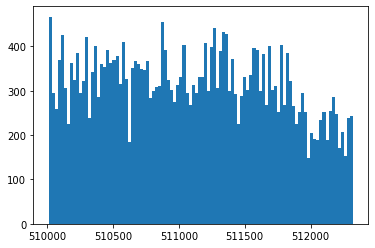

In [48]:
plt.hist(sip_train["NPLV"], bins=100);

In [49]:
feat_anal(sip_train["NPLV"])



feat name: NPLV
min | max values = 510008 | 512322
value range = 2314
No unique values = 2063
axis 1 shape = 31584
sum of Nan = 0


In [50]:
df = sip_train["NPLV"]

print(f"{df.name} уникален? ", df.is_unique)
print("Есть ли дубли в строках?", df.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((df.isnull().sum() > 0).sum()/len(df)*100))

NPLV уникален?  False
Есть ли дубли в строках? 29521
Сколько процент признаков могут принимать null-значениями? 0%


In [51]:
sip_test = pd.read_csv(path.joinpath('sip_test.csv'))
sip_test['DAT_OTD'] = sip_test['DAT_OTD'].apply(lambda x: pd.Timestamp(x))
sip_test

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,512324,408,изв_ЦОИ,3020,2021-05-05 17:38:59
1,512324,442,ФЛЮМАГ,1670,2021-05-05 17:42:07
2,512324,408,изв_ЦОИ,2810,2021-05-05 17:42:07
3,512324,346,Уголь ТО,140,2021-05-05 17:43:39
4,512324,346,Уголь ТО,70,2021-05-05 17:43:49
...,...,...,...,...,...
10457,513374,346,Уголь ТО,630,2021-06-29 22:44:40
10458,513374,346,Уголь ТО,2310,2021-06-29 22:46:17
10459,513374,408,изв_ЦОИ,10010,2021-06-29 22:46:23
10460,513374,346,Уголь ТО,670,2021-06-29 22:48:22


In [52]:
sip_test[sip_test['DAT_OTD'] < '2021']

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD


In [53]:
sip_test.iloc[0,-1]

Timestamp('2021-05-05 17:38:59')

## target: целевые значения

- C	- содержание углерода в металле
- TST	- температура металла
- NPLV	- номер плавки

In [54]:
target_train = pd.read_csv(path.joinpath('target_train.csv'))
target_train

,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091
3,510011,1609,0.410
4,510012,1682,0.120
...,...,...,...
2058,512318,1626,0.145
2059,512319,1643,0.087
2060,512320,1615,0.141
2061,512321,1654,0.270


In [55]:
target_train.isna().sum()

NPLV    0
TST     0
C       2
dtype: int64

**2 пропуска значения содержания углерода**

In [56]:
target_train['C'] = target_train['C'].fillna(target_train['C'].mean())

In [57]:
target_train.isna().sum()

NPLV    0
TST     0
C       0
dtype: int64

In [58]:
df = target_train["NPLV"]

print(f"{df.name} уникален? ", df.is_unique)
print("Есть ли дубли в строках?", df.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((df.isnull().sum() > 0).sum()/len(df)*100))

NPLV уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


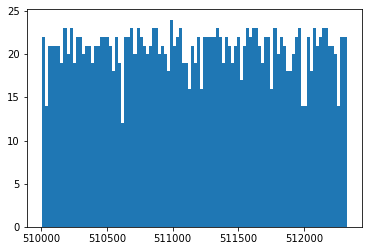

In [59]:
plt.hist(target_train["NPLV"], bins=100);

In [60]:
feat_anal(sip_train["NPLV"])

feat_anal(target_train["NPLV"])



feat name: NPLV
min | max values = 510008 | 512322
value range = 2314
No unique values = 2063
axis 1 shape = 31584
sum of Nan = 0


feat name: NPLV
min | max values = 510008 | 512322
value range = 2314
No unique values = 2063
axis 1 shape = 2063
sum of Nan = 0


# Идеи и выводы

- пропуски:
  - chronom_train имеет 15% пропусков
  - chronom_test 16%
  - targrt_train 2 пропущеных значения.

Идеи
- [ ] дропнуть 2011 год (всё что меньше 2021-го) `chronom_test[chronom_test['NPLV'] == 512324].sort_values(by='VR_NACH')`
- [ ] C - содержание углерода в металле - распределение скошенно - **логарифмировать**
- [ ] C - содержание углерода в металле - 2 пропущенных значения

# Baseline

## Анализ объединения на одной плавке

In [61]:
target_train[target_train['NPLV'] == 510008]

,NPLV,TST,C
0,510008,1690,0.06


In [62]:
lom_train[lom_train['NPLV'] == 510008]

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000


In [63]:
chugun_train[chugun_train['NPLV'] == 510008]

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03


In [64]:
sip_train[sip_train['NPLV'] == 510008].sort_values(by='DAT_OTD')

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
5,510008,346,Уголь ТО,1460,2021-01-01 03:10:22
6,510008,408,изв_ЦОИ,810,2021-01-01 03:11:39
7,510008,171,Флюс ФОМИ,980,2021-01-01 03:11:39
8,510008,442,ФЛЮМАГ,2960,2021-01-01 03:14:36
9,510008,408,изв_ЦОИ,2010,2021-01-01 03:27:26


In [65]:
gas_train[gas_train['NPLV'] == 510008].sort_values(by='Time')

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,0.006712,0.892358,0.0,0.0,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,0.005873,0.892063,0.0,0.0,13.093172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,510008,2021-01-01 03:51:06.437,218369.359375,131.944443,9.916870,78.370371,0.010074,10.185237,0.550623,0.973858,0.0,0.0,13.389757
2556,510008,2021-01-01 03:51:07.437,219426.875000,131.944443,9.929288,78.373759,0.010222,10.170386,0.549763,0.973769,0.0,0.0,13.389757
2557,510008,2021-01-01 03:51:08.437,219637.750000,131.944443,9.941707,78.377146,0.010370,10.155534,0.548902,0.973680,0.0,0.0,13.389757
2558,510008,2021-01-01 03:51:09.437,219321.343750,131.944443,9.954125,78.380534,0.010519,10.140683,0.548042,0.973591,0.0,0.0,13.389757


In [66]:
produv_train[produv_train['NPLV'] == 510008].sort_values(by='SEC')

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.000000,3.920000
1,510008,2021-01-01 03:18:28,382.000000,3.920000
2,510008,2021-01-01 03:18:30,553.000000,3.920000
3,510008,2021-01-01 03:18:32,701.000000,3.920000
4,510008,2021-01-01 03:18:34,813.000000,3.920000
...,...,...,...,...
2050,510008,2021-01-01 04:26:46,402.879076,3.542024
2051,510008,2021-01-01 04:26:48,403.103261,3.539620
2052,510008,2021-01-01 04:26:50,403.327446,3.537215
2053,510008,2021-01-01 04:26:52,403.551630,3.534810


In [67]:
chronom_train[chronom_train['NPLV'] == 510008].sort_values(by='VR_NACH')

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN
26,510008,опер,Завалка лома,2021-01-01 03:08:11,2021-01-01 03:08:27,NaN
27,510008,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,NaN
33235,510008,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,2909.0
28,510008,опер,Заливка чугуна,2021-01-01 03:15:02,2021-01-01 03:18:25,NaN
29,510008,опер,Продувка,2021-01-01 03:18:25,2021-01-01 03:37:55,NaN


# Объединение датафреймов

## target_train + chugun_train

In [68]:
target_train = pd.merge(target_train, chugun_train, on='NPLV', how='inner')

In [69]:
print(target_train.shape)
target_train.head(3)

(2063, 15)


,NPLV,TST,C,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40


In [70]:
for col in target_train.columns:
    print([col])

['NPLV']
['TST']
['C']
['VES']
['T']
['SI']
['MN']
['S']
['P']
['CR']
['NI']
['CU']
['V']
['TI']
['DATA_ZAMERA']


In [71]:
lom_train

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000
3,510009,4,К,49800
4,510009,8,О,22800
...,...,...,...,...
6371,512321,8,О,4200
6372,512321,13,КП,3000
6373,512322,4,К,66700
6374,512322,13,КП,6000


In [72]:
# список уникальных значений по категориальным фичам
for column in lom_train.columns[:-1]:
    print(f'{column}: {lom_train[column].unique()} \n')

NPLV: [510008 510009 510010 ... 512320 512321 512322] 

VDL: [ 4  8 13 23 61 20 48 49 63  3] 

NML: ['К   ' 'О   ' 'КП  ' 'ЛЧ  ' 'КШС8' 'ОК  ' 'У2КШ' '25КШ' 'СК  ' 'НБ  '] 



In [73]:
lom_train.shape

(6376, 4)

In [74]:
lom_train.head(7)

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000
3,510009,4,К,49800
4,510009,8,О,22800
5,510009,13,КП,6000
6,510010,4,К,45900


In [75]:
lom_train[lom_train['NPLV'] == 512318]

,NPLV,VDL,NML,VES
6358,512318,4,К,51700
6359,512318,13,КП,3000
6360,512318,23,ЛЧ,11500
6361,512318,8,О,3300
6362,512318,48,У2КШ,4100


In [76]:
# список уникальных значений по категориальным фичам
for column in lom_train.columns[:-1]:
    print(f'{column}: {lom_train[column].unique()} \n')

NPLV: [510008 510009 510010 ... 512320 512321 512322] 

VDL: [ 4  8 13 23 61 20 48 49 63  3] 

NML: ['К   ' 'О   ' 'КП  ' 'ЛЧ  ' 'КШС8' 'ОК  ' 'У2КШ' '25КШ' 'СК  ' 'НБ  '] 



## lom.pivot

In [77]:
lom = pd.concat([lom_train, lom_test], axis=0)
lom

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000
3,510009,4,К,49800
4,510009,8,О,22800
...,...,...,...,...
2627,513372,48,У2КШ,500
2628,513374,4,К,54400
2629,513374,13,КП,7000
2630,513374,8,О,9100


In [78]:
lom['NML'] = lom['NML'].apply(lambda x: x.replace(' ', ''))
lom['NML'] = lom['NML'].apply(lambda x: x.translate(tr))

In [79]:
lom

,NPLV,VDL,NML,VES
0,510008,4,K,56500
1,510008,8,O,16700
2,510008,13,KP,3000
3,510009,4,K,49800
4,510009,8,O,22800
...,...,...,...,...
2627,513372,48,U2KS,500
2628,513374,4,K,54400
2629,513374,13,KP,7000
2630,513374,8,O,9100


In [80]:
# lom_train_pivot = lom_train.pivot_table(index=['NPLV'], columns=['VDL', 'NML'], values='VES', fill_value=0).reset_index()
# lom_train_pivot.columns = [(str(a) + '_' + str(b)) for a, b in lom_train_pivot.columns.tolist()]
# lom_train_pivot = lom_train_pivot.rename(columns={'NPLV_': 'NPLV'})
# print('DataFrame has MultiIndex:', isinstance(lom_train_pivot.index, pd.MultiIndex))
# lom_train_pivot

lom_pivot = lom.pivot(index='NPLV', columns=['VDL', 'NML'], values=['VES'])
lom_pivot.columns = [(str(a) + '_' + str(b) + '_' + str(c)) for a, b, c in lom_pivot.columns.tolist()]
#lom_pivot.columns = lom_pivot.columns.str.replace(' ','')
lom_pivot = lom_pivot.fillna(0)
print('DataFrame has MultiIndex:', isinstance(lom_pivot.index, pd.MultiIndex))
lom_pivot

DataFrame has MultiIndex: False


,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
NPLV,,,,,,,,,,
510008,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510009,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510010,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0
510011,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510012,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
513369,52700.0,2300.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
513370,52700.0,0.0,3000.0,0.0,0.0,0.0,6600.0,0.0,0.0,0.0
513371,60100.0,0.0,6000.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
len(set(lom_pivot.columns.to_list())), set(lom_pivot.columns.to_list())

(10,
 {'VES_13_KP',
  'VES_20_OK',
  'VES_23_LC',
  'VES_3_NB',
  'VES_48_U2KS',
  'VES_49_25KS',
  'VES_4_K',
  'VES_61_KSS8',
  'VES_63_SK',
  'VES_8_O'})

In [82]:
lom_train = lom_pivot[lom_pivot.index < 512323].reset_index()
lom_test = lom_pivot[lom_pivot.index > 512323].reset_index()

In [83]:
lom_train

,NPLV,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,510008,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,510009,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,510010,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0
3,510011,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510012,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,51700.0,3300.0,3000.0,11500.0,0.0,0.0,4100.0,0.0,0.0,0.0
2059,512319,46400.0,15300.0,5000.0,9900.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,512320,41400.0,0.0,5000.0,0.0,0.0,0.0,17800.0,0.0,0.0,0.0
2061,512321,59000.0,4200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
lom_test

,NPLV,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,512324,26040.0,17660.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,512327,49400.0,10600.0,3000.0,8000.0,0.0,0.0,0.0,0.0,0.0,0.0
2,512328,65700.0,0.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,512331,36000.0,32500.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,512333,40300.0,62200.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
775,513369,52700.0,2300.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,513370,52700.0,0.0,3000.0,0.0,0.0,0.0,6600.0,0.0,0.0,0.0
777,513371,60100.0,0.0,6000.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0
778,513372,59600.0,3100.0,3000.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0


### target_train + lom_train_pivot

In [85]:
target_train = pd.merge(target_train, lom_train, on='NPLV', how='inner')

In [86]:
target_train

,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0
3,510011,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,...,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510012,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,...,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1626,0.145,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,...,51700.0,3300.0,3000.0,11500.0,0.0,0.0,4100.0,0.0,0.0,0.0
2059,512319,1643,0.087,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,...,46400.0,15300.0,5000.0,9900.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,512320,1615,0.141,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,...,41400.0,0.0,5000.0,0.0,0.0,0.0,17800.0,0.0,0.0,0.0
2061,512321,1654,0.270,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,...,59000.0,4200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### chugun_test + lom_test_pivot

In [87]:
test = pd.merge(chugun_test, lom_test, on='NPLV', how='inner')
print(test.shape)
test

(780, 23)


,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,26040.0,17660.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,49400.0,10600.0,3000.0,8000.0,0.0,0.0,0.0,0.0,0.0,0.0
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,65700.0,0.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,512331,266700.0,1383.0,0.54,0.39,0.028,0.115,0.02,0.01,0.03,...,36000.0,32500.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,512333,267400.0,1387.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,40300.0,62200.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,513369,280800.0,1324.0,0.35,0.29,0.035,0.096,0.01,0.01,0.02,...,52700.0,2300.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,513370,280600.0,1389.0,0.39,0.31,0.024,0.097,0.01,0.01,0.02,...,52700.0,0.0,3000.0,0.0,0.0,0.0,6600.0,0.0,0.0,0.0
777,513371,279700.0,1332.0,0.30,0.27,0.031,0.099,0.01,0.01,0.02,...,60100.0,0.0,6000.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0
778,513372,279700.0,1378.0,0.43,0.33,0.026,0.113,0.01,0.01,0.02,...,59600.0,3100.0,3000.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0


In [88]:
list(set(target_train.columns) - set(test.columns))

['C', 'TST']

**Разница трейна и теста в 2-х стобцах - это таргеты**

In [89]:
test.head(2)

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,26040.0,17660.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,49400.0,10600.0,3000.0,8000.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
target_train.head(2)

,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
target_train.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_K', 'VES_8_O', 'VES_13_KP',
       'VES_23_LC', 'VES_61_KSS8', 'VES_20_OK', 'VES_48_U2KS', 'VES_49_25KS',
       'VES_63_SK', 'VES_3_NB'],
      dtype='object')

## chronom train + test - категориальные

In [92]:
chronom_train.head(5)

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN


In [93]:
chronom_test.head(2)

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
1,512324,межпл.прост.,межпл. простой,2021-05-05 17:35:55,2021-05-05 17:41:21,NaN
2,512324,межпл.прост.,Осмотр конвертера,2021-05-05 17:36:07,2021-05-05 17:39:07,NaN


In [94]:
# список уникальных значений по категориальным фичам
for column in ['TYPE_OPER', 'NOP']:
    print(f'{column}: {chronom_train[column].unique()} \n Кол-во уникальных: {chronom_train[column].nunique()} \n')

TYPE_OPER: ['межпл.прост.' 'опер' 'вн.пл.прост.'] 
 Кол-во уникальных: 3 

NOP: ['межпл. простой' 'Осмотр конвертера' 'Наведение гарнисажа' 'Слив шлака'
 'Отсутствие O2' 'Завалка лома' 'Нагрев лома' 'Заливка чугуна' 'Продувка'
 'Повалка' 'Ожидание стальковша' 'Выпуск металла' 'Прерыв. выпуска'
 'Вхождение в гр.МНЛЗ' 'Обрыв горловины' 'Додувка на t'
 'Наложение продувки' 'Охл. азотом' 'Подварка  футеровки'
 'Отсутствие чугуна' 'Отсечка шлака' 'Додувка на C' 'Неиспр. механ. обор.'
 'Неиспр. электр. обор' 'Ремонт летки' 'Замена фурмы'
 'Отсутствие мет.шихты' 'Полусухое торкрет.' 'ППР' 'Отсут. своб.разл.пл.'
 'Замер положения фурм' 'Ожидание шл.чаш' 'Неиспр. энерг. обор'
 'Скач. шлака'] 
 Кол-во уникальных: 34 



In [95]:
chronom = pd.concat([chronom_train, chronom_test], axis=0)
chronom

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN
...,...,...,...,...,...,...
7840,513374,опер,Завалка лома,2021-06-29 22:43:02,2021-06-29 22:43:54,NaN
7841,513374,опер,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,NaN
7842,513374,опер,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,1797.0
7843,513374,опер,Заливка чугуна,2021-06-29 22:50:07,2021-06-29 22:53:43,NaN


In [96]:
chronom[chronom['NPLV'] == 510008]

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN
26,510008,опер,Завалка лома,2021-01-01 03:08:11,2021-01-01 03:08:27,NaN
27,510008,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,NaN
33235,510008,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,2909.0
28,510008,опер,Заливка чугуна,2021-01-01 03:15:02,2021-01-01 03:18:25,NaN
29,510008,опер,Продувка,2021-01-01 03:18:25,2021-01-01 03:37:55,NaN


In [97]:
# удаляем типы операции ('межпл.прост.' и 'вн.пл.прост.')
chronom = chronom.drop(chronom[chronom['TYPE_OPER'] != 'опер'].index, axis=0)
# удаляем столбец типа операции
chronom = chronom.drop(['TYPE_OPER'], axis=1)
chronom

,NPLV,NOP,VR_NACH,VR_KON,O2
33235,510008,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,2909.0
29,510008,Продувка,2021-01-01 03:18:25,2021-01-01 03:37:55,NaN
32,510008,Прерыв. выпуска,2021-01-01 03:50:10,2021-01-01 03:51:10,NaN
33,510008,Слив шлака,2021-01-01 03:51:10,2021-01-01 03:51:10,NaN
34,510009,Завалка лома,2021-01-01 04:00:44,2021-01-01 04:01:15,NaN
...,...,...,...,...,...
7840,513374,Завалка лома,2021-06-29 22:43:02,2021-06-29 22:43:54,NaN
7841,513374,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,NaN
7842,513374,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,1797.0
7843,513374,Заливка чугуна,2021-06-29 22:50:07,2021-06-29 22:53:43,NaN


In [98]:
# время операции в секундах
chronom['durat'] = (chronom['VR_KON'] - chronom['VR_NACH']).astype('timedelta64[s]')
chronom

,NPLV,NOP,VR_NACH,VR_KON,O2,durat
33235,510008,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,2909.0,365.0
29,510008,Продувка,2021-01-01 03:18:25,2021-01-01 03:37:55,NaN,1170.0
32,510008,Прерыв. выпуска,2021-01-01 03:50:10,2021-01-01 03:51:10,NaN,60.0
33,510008,Слив шлака,2021-01-01 03:51:10,2021-01-01 03:51:10,NaN,0.0
34,510009,Завалка лома,2021-01-01 04:00:44,2021-01-01 04:01:15,NaN,31.0
...,...,...,...,...,...,...
7840,513374,Завалка лома,2021-06-29 22:43:02,2021-06-29 22:43:54,NaN,52.0
7841,513374,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,NaN,365.0
7842,513374,Нагрев лома,2021-06-29 22:43:54,2021-06-29 22:49:59,1797.0,365.0
7843,513374,Заливка чугуна,2021-06-29 22:50:07,2021-06-29 22:53:43,NaN,216.0


In [99]:
chronom = chronom.drop(['VR_NACH', 'VR_KON'], axis=1)
chronom

,NPLV,NOP,O2,durat
33235,510008,Нагрев лома,2909.0,365.0
29,510008,Продувка,NaN,1170.0
32,510008,Прерыв. выпуска,NaN,60.0
33,510008,Слив шлака,NaN,0.0
34,510009,Завалка лома,NaN,31.0
...,...,...,...,...
7840,513374,Завалка лома,NaN,52.0
7841,513374,Нагрев лома,NaN,365.0
7842,513374,Нагрев лома,1797.0,365.0
7843,513374,Заливка чугуна,NaN,216.0


In [100]:
chronom[chronom['NPLV'] < 510011]

,NPLV,NOP,O2,durat
33235,510008,Нагрев лома,2909.0,365.0
29,510008,Продувка,NaN,1170.0
32,510008,Прерыв. выпуска,NaN,60.0
33,510008,Слив шлака,NaN,0.0
34,510009,Завалка лома,NaN,31.0
33236,510009,Нагрев лома,2182.0,394.0
37,510009,Продувка,NaN,1230.0
39,510009,Выпуск металла,NaN,335.0
40,510009,Прерыв. выпуска,NaN,60.0
41,510009,Слив шлака,NaN,0.0


In [101]:
chronom['NOP'] = chronom['NOP'].apply(lambda x: x.replace(' ', ''))
chronom['NOP'] = chronom['NOP'].apply(lambda x: x.translate(tr))

In [102]:
chronom

,NPLV,NOP,O2,durat
33235,510008,Nagrevloma,2909.0,365.0
29,510008,Produvka,NaN,1170.0
32,510008,Preryv.vypuska,NaN,60.0
33,510008,Slivslaka,NaN,0.0
34,510009,Zavalkaloma,NaN,31.0
...,...,...,...,...
7840,513374,Zavalkaloma,NaN,52.0
7841,513374,Nagrevloma,NaN,365.0
7842,513374,Nagrevloma,1797.0,365.0
7843,513374,Zalivkacuguna,NaN,216.0


In [103]:
chronom_pivot = chronom.pivot_table(index=['NPLV'], columns=['NOP'], values=['O2', 'durat'], fill_value=0)
chronom_pivot = chronom_pivot.reset_index()
chronom_pivot.columns = [(str(a) + '_' + str(b)) for a, b in chronom_pivot.columns.tolist()]
chronom_pivot = chronom_pivot.rename(columns={'NPLV_': 'NPLV'})
print('DataFrame has MultiIndex:', isinstance(chronom_pivot.index, pd.MultiIndex))
chronom_pivot[chronom_pivot['NPLV'] < 510012]

DataFrame has MultiIndex: False


,NPLV,O2_DoduvkanaC,O2_Doduvkanat,O2_Nagrevloma,O2_Ohl.azotom,O2_Otseckaslaka,O2_Povalka,O2_Preryv.vypuska,O2_Produvka,O2_Skac.slaka,...,durat_Ohl.azotom,durat_Otseckaslaka,durat_Povalka,durat_Preryv.vypuska,durat_Produvka,durat_Skac.slaka,durat_Slivslaka,durat_Vypuskmetalla,durat_Zalivkacuguna,durat_Zavalkaloma
0,510008,0.0,0.0,2909.0,0,0,0,0,0,0,...,0.0,0,0.0,60,1170,0,0,0.0,0,0
1,510009,0.0,0.0,2182.0,0,0,0,0,0,0,...,0.0,0,0.0,60,1230,0,0,335.0,0,31
2,510010,0.0,0.0,2841.0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,313.0,0,0
3,510011,0.0,0.0,10.0,0,0,0,0,0,0,...,0.0,0,495.0,60,0,0,0,338.0,0,17


### Делим chronom на трейн и тест

In [104]:
chronom_pivot.shape

(2843, 27)

In [105]:
chronom_train['NPLV'].min(), chronom_train['NPLV'].max(), chronom_test['NPLV'].min(), chronom_test['NPLV'].max()

(510008, 512322, 512324, 513374)

In [106]:
chronom_train = chronom_pivot[chronom_pivot['NPLV'] < 512323]
chronom_train

,NPLV,O2_DoduvkanaC,O2_Doduvkanat,O2_Nagrevloma,O2_Ohl.azotom,O2_Otseckaslaka,O2_Povalka,O2_Preryv.vypuska,O2_Produvka,O2_Skac.slaka,...,durat_Ohl.azotom,durat_Otseckaslaka,durat_Povalka,durat_Preryv.vypuska,durat_Produvka,durat_Skac.slaka,durat_Slivslaka,durat_Vypuskmetalla,durat_Zalivkacuguna,durat_Zavalkaloma
0,510008,0.0,0.0,2909.0,0,0,0,0,0,0,...,0.0,0,0.0,60,1170,0,0,0.0,0,0
1,510009,0.0,0.0,2182.0,0,0,0,0,0,0,...,0.0,0,0.0,60,1230,0,0,335.0,0,31
2,510010,0.0,0.0,2841.0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,313.0,0,0
3,510011,0.0,0.0,10.0,0,0,0,0,0,0,...,0.0,0,495.0,60,0,0,0,338.0,0,17
4,510012,0.0,1094.0,2131.0,0,0,0,0,0,0,...,0.0,0,233.0,0,1239,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,0.0,1917.0,0.0,0,0,0,0,0,0,...,0.0,0,592.5,40,1063,0,20,299.0,242,102
2059,512319,1660.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,295.0,60,1108,0,0,316.0,224,1415
2060,512320,0.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,438.5,42,1058,0,18,324.0,315,534
2061,512321,371.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,584.5,54,1169,0,6,409.0,160,645


In [107]:
chronom_test = chronom_pivot[chronom_pivot['NPLV'] > 512323]
chronom_test

,NPLV,O2_DoduvkanaC,O2_Doduvkanat,O2_Nagrevloma,O2_Ohl.azotom,O2_Otseckaslaka,O2_Povalka,O2_Preryv.vypuska,O2_Produvka,O2_Skac.slaka,...,durat_Ohl.azotom,durat_Otseckaslaka,durat_Povalka,durat_Preryv.vypuska,durat_Produvka,durat_Skac.slaka,durat_Slivslaka,durat_Vypuskmetalla,durat_Zalivkacuguna,durat_Zavalkaloma
2063,512324,0.0,0.0,1452.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1263,0,0,0.0,143,115
2064,512327,0.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1074,0,0,0.0,578,114
2065,512328,0.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1122,0,0,0.0,150,2096
2066,512331,0.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1103,0,0,0.0,221,3015
2067,512333,0.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1096,0,0,0.0,199,1478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,513369,0.0,0.0,2433.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1213,0,0,0.0,289,225
2839,513370,0.0,0.0,2232.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1161,0,0,0.0,371,158
2840,513371,0.0,0.0,1904.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1181,0,0,0.0,356,131
2841,513372,0.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,1335,0,0,0.0,174,105


### target_train + chronom_train (pivoted)

In [108]:
target_train

,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0
3,510011,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,...,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510012,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,...,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1626,0.145,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,...,51700.0,3300.0,3000.0,11500.0,0.0,0.0,4100.0,0.0,0.0,0.0
2059,512319,1643,0.087,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,...,46400.0,15300.0,5000.0,9900.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,512320,1615,0.141,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,...,41400.0,0.0,5000.0,0.0,0.0,0.0,17800.0,0.0,0.0,0.0
2061,512321,1654,0.270,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,...,59000.0,4200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
target_train = pd.merge(target_train, chronom_train, on='NPLV', how='inner')

In [110]:
target_train

,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,durat_Ohl.azotom,durat_Otseckaslaka,durat_Povalka,durat_Preryv.vypuska,durat_Produvka,durat_Skac.slaka,durat_Slivslaka,durat_Vypuskmetalla,durat_Zalivkacuguna,durat_Zavalkaloma
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0.0,0,0.0,60,1170,0,0,0.0,0,0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0.0,0,0.0,60,1230,0,0,335.0,0,31
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0.0,0,0.0,0,0,0,0,313.0,0,0
3,510011,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,...,0.0,0,495.0,60,0,0,0,338.0,0,17
4,510012,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,...,0.0,0,233.0,0,1239,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1626,0.145,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,...,0.0,0,592.5,40,1063,0,20,299.0,242,102
2059,512319,1643,0.087,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,...,0.0,0,295.0,60,1108,0,0,316.0,224,1415
2060,512320,1615,0.141,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,...,0.0,0,438.5,42,1058,0,18,324.0,315,534
2061,512321,1654,0.270,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,...,0.0,0,584.5,54,1169,0,6,409.0,160,645


### test + chronom_test (pivoted)

In [111]:
test

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,VES_4_K,VES_8_O,VES_13_KP,VES_23_LC,VES_61_KSS8,VES_20_OK,VES_48_U2KS,VES_49_25KS,VES_63_SK,VES_3_NB
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,26040.0,17660.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,49400.0,10600.0,3000.0,8000.0,0.0,0.0,0.0,0.0,0.0,0.0
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,65700.0,0.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,512331,266700.0,1383.0,0.54,0.39,0.028,0.115,0.02,0.01,0.03,...,36000.0,32500.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,512333,267400.0,1387.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,40300.0,62200.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,513369,280800.0,1324.0,0.35,0.29,0.035,0.096,0.01,0.01,0.02,...,52700.0,2300.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,513370,280600.0,1389.0,0.39,0.31,0.024,0.097,0.01,0.01,0.02,...,52700.0,0.0,3000.0,0.0,0.0,0.0,6600.0,0.0,0.0,0.0
777,513371,279700.0,1332.0,0.30,0.27,0.031,0.099,0.01,0.01,0.02,...,60100.0,0.0,6000.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0
778,513372,279700.0,1378.0,0.43,0.33,0.026,0.113,0.01,0.01,0.02,...,59600.0,3100.0,3000.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0


In [112]:
test = pd.merge(test, chronom_test, on='NPLV', how='inner')

In [113]:
test

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,durat_Ohl.azotom,durat_Otseckaslaka,durat_Povalka,durat_Preryv.vypuska,durat_Produvka,durat_Skac.slaka,durat_Slivslaka,durat_Vypuskmetalla,durat_Zalivkacuguna,durat_Zavalkaloma
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0.0,0,0.0,0,1263,0,0,0.0,143,115
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0.0,0,0.0,0,1074,0,0,0.0,578,114
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0.0,0,0.0,0,1122,0,0,0.0,150,2096
3,512331,266700.0,1383.0,0.54,0.39,0.028,0.115,0.02,0.01,0.03,...,0.0,0,0.0,0,1103,0,0,0.0,221,3015
4,512333,267400.0,1387.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0.0,0,0.0,0,1096,0,0,0.0,199,1478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,513369,280800.0,1324.0,0.35,0.29,0.035,0.096,0.01,0.01,0.02,...,0.0,0,0.0,0,1213,0,0,0.0,289,225
776,513370,280600.0,1389.0,0.39,0.31,0.024,0.097,0.01,0.01,0.02,...,0.0,0,0.0,0,1161,0,0,0.0,371,158
777,513371,279700.0,1332.0,0.30,0.27,0.031,0.099,0.01,0.01,0.02,...,0.0,0,0.0,0,1181,0,0,0.0,356,131
778,513372,279700.0,1378.0,0.43,0.33,0.026,0.113,0.01,0.01,0.02,...,0.0,0,0.0,0,1335,0,0,0.0,174,105


## plavki

In [114]:
feat_anal(target_train["NPLV"])
feat_anal(plavki_train["NPLV"])



feat name: NPLV
min | max values = 510008 | 512322
value range = 2314
No unique values = 2063
axis 1 shape = 2063
sum of Nan = 0


feat name: NPLV
min | max values = 510008 | 512322
value range = 2314
No unique values = 2063
axis 1 shape = 2137
sum of Nan = 0


In [115]:
print("ID уникален? ", plavki_train["NPLV"].is_unique)
print("Есть ли дубли в строках?", plavki_train["NPLV"].duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((plavki_train["NPLV"].isnull().sum() > 0).sum()/len(plavki_train["NPLV"])*100))

ID уникален?  False
Есть ли дубли в строках? 74
Сколько процент признаков могут принимать null-значениями? 0%


In [116]:
# датафрейм дубликатов
ids = plavki_train["NPLV"]
plavki_train[ids.isin(ids[ids.duplicated()])].sort_values("NPLV")

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
1007,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,63,5 сопловая,161
1060,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,25,5 сопловая,25
1059,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,24,5 сопловая,24
1058,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,23,5 сопловая,23
1057,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,22,5 сопловая,22
...,...,...,...,...,...,...,...,...,...,...
1029,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,85,5 сопловая,183
1028,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,84,5 сопловая,182
1027,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,83,5 сопловая,181
1025,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,81,5 сопловая,179


**Плавка с номером NPLV = 511135 имеет 75 значений - что-то не то. Выкинуть?**

In [117]:
plavki = pd.concat([plavki_train, plavki_test], axis=0)
plavki

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
...,...,...,...,...,...,...,...,...,...,...
775,513369,2021-06-29 17:08:33,2021-06-29 17:55:50,Ст3сп/Т,МНЛЗ,1047,цилиндрическая,2,601-5,2
776,513370,2021-06-29 18:03:00,2021-06-29 18:49:50,Ст3сп/Т,МНЛЗ,1048,цилиндрическая,3,601-5,3
777,513371,2021-06-29 18:55:21,2021-06-29 19:53:39,Ст3сп/Т,МНЛЗ,1049,цилиндрическая,4,601-5,4
778,513372,2021-06-29 20:18:40,2021-06-29 20:59:18,Ст3сп/Т,МНЛЗ,1050,цилиндрическая,5,601-5,5


Удаляем 74 строки и оставляем одну первую

In [118]:
plavki = plavki.drop(plavki[(plavki['NPLV']  == 511135) & (plavki['plavka_ST_FURM'] != 63)].index, axis=0)
plavki

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
...,...,...,...,...,...,...,...,...,...,...
775,513369,2021-06-29 17:08:33,2021-06-29 17:55:50,Ст3сп/Т,МНЛЗ,1047,цилиндрическая,2,601-5,2
776,513370,2021-06-29 18:03:00,2021-06-29 18:49:50,Ст3сп/Т,МНЛЗ,1048,цилиндрическая,3,601-5,3
777,513371,2021-06-29 18:55:21,2021-06-29 19:53:39,Ст3сп/Т,МНЛЗ,1049,цилиндрическая,4,601-5,4
778,513372,2021-06-29 20:18:40,2021-06-29 20:59:18,Ст3сп/Т,МНЛЗ,1050,цилиндрическая,5,601-5,5


In [119]:
plavki['dur_plavka'] = (plavki['plavka_VR_KON'] - plavki['plavka_VR_NACH']).astype('timedelta64[s]')
print(plavki.shape)
plavki.head(3)

(2843, 11)


<ipython-input-119-63ec016f915b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plavki['dur_plavka'] = (plavki['plavka_VR_KON'] - plavki['plavka_VR_NACH']).astype('timedelta64[s]')


,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,dur_plavka
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11,2579.0
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12,4004.0
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13,2904.0


In [120]:
plavki = plavki.drop(['plavka_VR_NACH', 'plavka_VR_KON'], axis=1)

In [121]:
plavki.head(5)

,NPLV,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,dur_plavka
0,510008,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11,2579.0
1,510009,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12,4004.0
2,510010,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13,2904.0
3,510011,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14,3291.0
4,510012,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15,2895.0


In [122]:
plavki['plavka_NMZ'] = plavki['plavka_NMZ'].apply(lambda x: x.replace(' ', ''))
plavki['plavka_NMZ'] = plavki['plavka_NMZ'].apply(lambda x: x.translate(tr))
plavki['plavka_NMZ'] = plavki['plavka_NMZ'].apply(lambda x: x.replace('/', '_'))
plavki['plavka_NMZ'] = plavki['plavka_NMZ'].apply(lambda x: x.replace(',', '_'))

plavki['plavka_NAPR_ZAD'] = plavki['plavka_NAPR_ZAD'].apply(lambda x: x.replace(' ', ''))
plavki['plavka_NAPR_ZAD'] = plavki['plavka_NAPR_ZAD'].apply(lambda x: x.translate(tr))

plavki['plavka_TIPE_FUR'] = plavki['plavka_TIPE_FUR'].apply(lambda x: x.replace(' ', ''))
plavki['plavka_TIPE_FUR'] = plavki['plavka_TIPE_FUR'].apply(lambda x: x.translate(tr))

plavki['plavka_TIPE_GOL'] = plavki['plavka_TIPE_GOL'].apply(lambda x: x.replace(' ', ''))
plavki['plavka_TIPE_GOL'] = plavki['plavka_TIPE_GOL'].apply(lambda x: x.translate(tr))
plavki['plavka_TIPE_GOL'] = plavki['plavka_TIPE_GOL'].apply(lambda x: x.replace(',', '_'))

In [123]:
# список уникальных значений по категориальным фичам
for column in plavki.columns[1:-1]:
    print(f'{column}: {plavki[column].unique()} \n Кол-во уникальных: {plavki[column].nunique()} \n')

plavka_NMZ: ['S255' 'St3ps_E' 'Sv-08A.z02' 'SC2M_ET' 'S2.1' 'SC2_ET' '25G2S' 'S2.3'
 'St2ps' 'HRB400E.z03_ET' '4SP.z08_ET' 'ST3GSP.2' '45' '09G2S.16'
 'ST3PS.6' 'St1ps_E' '20' 'St1kp' 'St1ps' '18G2S.FS' 'St3sp_E' 'ST3GPS.8'
 '5SP.z16_ET' 'St1kp_E' '10YU.z02_ET' '28S.2' 'SAE1006.z03_ET' 'St3sp'
 '35GS' 'SPHC.z03_ET' '09G2S' 'St5sp' '35' 'SV08A' '1PS.z01_ET' 'St4sp'
 'St1ps.z02_ET' 'GR60.z06_ET' '40H.1' 'CQ2-G60_ET' '26S2.2' '28S'
 '10HSND.1' 'SV08G2S.2' '3PS.z03_E' 'SP325_ET' 'G_ET' 'C071TM.z01_ET'
 'C06ESM.z01_ET' 'St3Gps' '20.z22' '15HSND' '09G2S.4' 'St2kp' 'St2ps_E'
 'C091TM.z01_ET' 'GR60.z02_ET' 'St5ps' '10B33_ET' 'SC3.z01_ET'
 '3SPPS.z03_E' 'SAE1008.z13_ET' '09G2SDP155' '09G2S.18' '1PS.z02_ET'
 '3SP.z23_ET' 'C121TM_ET' '08YU.z02_ET' 'ST3PS.7' '3SP.z24_ET'
 '5SP.z24_ET' 'St1ps.z05_ET' 'ST3GSP.4' 'St3sp_T' 'St4sp_ET' 'St3sp_ET'
 'St3ps'] 
 Кол-во уникальных: 77 

plavka_NAPR_ZAD: ['MNLZ' 'Izl' 'MNLS'] 
 Кол-во уникальных: 3 

plavka_STFUT: [ 971  972  973 ... 1028 1048 1049] 
 Кол-во

In [124]:
plavki

,NPLV,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,dur_plavka
0,510008,S255,MNLZ,971,zilindriceskaa,11,5soplovaa,11,2579.0
1,510009,S255,MNLZ,972,zilindriceskaa,12,5soplovaa,12,4004.0
2,510010,St3ps_E,Izl,973,zilindriceskaa,13,5soplovaa,13,2904.0
3,510011,Sv-08A.z02,Izl,974,zilindriceskaa,14,5soplovaa,14,3291.0
4,510012,SC2M_ET,MNLS,975,zilindriceskaa,15,5soplovaa,15,2895.0
...,...,...,...,...,...,...,...,...,...
775,513369,St3sp_T,MNLZ,1047,zilindriceskaa,2,601-5,2,2837.0
776,513370,St3sp_T,MNLZ,1048,zilindriceskaa,3,601-5,3,2810.0
777,513371,St3sp_T,MNLZ,1049,zilindriceskaa,4,601-5,4,3498.0
778,513372,St3sp_T,MNLZ,1050,zilindriceskaa,5,601-5,5,2438.0


In [125]:
def create_dummy_features(df: pd.DataFrame, categorical: List[str], drop: bool) -> pd.DataFrame:
    """
    Создание One-Hot-Enconding признаков для категориальных переменных.

    Parameters
    ----------
    df: pandas.core.frame.DataFrame
        Матрица признаков

    categorical: List[str]
        Список категориальных признаков.
        
    drop: boolean
          Удаление исходных категориальных признаков

    Returns
    -------
    df_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков
    """
    
    df = df.copy()
    
    if categorical:
        dummies = pd.get_dummies(
            df[categorical], 
            #prefix=categorical, 
            dummy_na=False,
        )
        return pd.concat([df.drop(categorical, axis=1), dummies], axis=1) if drop else pd.concat([df, dummies], axis=1)

# one-hot encoding признака 'Скважина'
plavki_col = create_dummy_features(plavki, ['plavka_NMZ', 'plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL'],
                                   drop=True)
plavki_col.head(2)

,NPLV,plavka_STFUT,plavka_ST_FURM,plavka_ST_GOL,dur_plavka,plavka_NMZ_08YU.z02_ET,plavka_NMZ_09G2S,plavka_NMZ_09G2S.16,plavka_NMZ_09G2S.18,plavka_NMZ_09G2S.4,...,plavka_NAPR_ZAD_MNLZ,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54
0,510008,971,11,11,2579.0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
1,510009,972,12,12,4004.0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


In [126]:
len(plavki_col.columns), len(set(plavki_col.columns)), plavki_col.columns

(94,
 94,
 Index(['NPLV', 'plavka_STFUT', 'plavka_ST_FURM', 'plavka_ST_GOL', 'dur_plavka',
        'plavka_NMZ_08YU.z02_ET', 'plavka_NMZ_09G2S', 'plavka_NMZ_09G2S.16',
        'plavka_NMZ_09G2S.18', 'plavka_NMZ_09G2S.4', 'plavka_NMZ_09G2SDP155',
        'plavka_NMZ_10B33_ET', 'plavka_NMZ_10HSND.1', 'plavka_NMZ_10YU.z02_ET',
        'plavka_NMZ_15HSND', 'plavka_NMZ_18G2S.FS', 'plavka_NMZ_1PS.z01_ET',
        'plavka_NMZ_1PS.z02_ET', 'plavka_NMZ_20', 'plavka_NMZ_20.z22',
        'plavka_NMZ_25G2S', 'plavka_NMZ_26S2.2', 'plavka_NMZ_28S',
        'plavka_NMZ_28S.2', 'plavka_NMZ_35', 'plavka_NMZ_35GS',
        'plavka_NMZ_3PS.z03_E', 'plavka_NMZ_3SP.z23_ET',
        'plavka_NMZ_3SP.z24_ET', 'plavka_NMZ_3SPPS.z03_E', 'plavka_NMZ_40H.1',
        'plavka_NMZ_45', 'plavka_NMZ_4SP.z08_ET', 'plavka_NMZ_5SP.z16_ET',
        'plavka_NMZ_5SP.z24_ET', 'plavka_NMZ_C06ESM.z01_ET',
        'plavka_NMZ_C071TM.z01_ET', 'plavka_NMZ_C091TM.z01_ET',
        'plavka_NMZ_C121TM_ET', 'plavka_NMZ_CQ2-G60_ET',
  

In [127]:
plavki_train = plavki_col[plavki_col['NPLV'] < 512323]
plavki_train

,NPLV,plavka_STFUT,plavka_ST_FURM,plavka_ST_GOL,dur_plavka,plavka_NMZ_08YU.z02_ET,plavka_NMZ_09G2S,plavka_NMZ_09G2S.16,plavka_NMZ_09G2S.18,plavka_NMZ_09G2S.4,...,plavka_NAPR_ZAD_MNLZ,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54
0,510008,971,11,11,2579.0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
1,510009,972,12,12,4004.0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
2,510010,973,13,13,2904.0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,510011,974,14,14,3291.0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,510012,975,15,15,2895.0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,512318,3281,22,56,3084.0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2133,512319,3282,23,57,3843.0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2134,512320,3283,24,58,3305.0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
2135,512321,3284,25,59,3660.0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0


In [128]:
plavki_test = plavki_col[plavki_col['NPLV'] > 512323]
plavki_test

,NPLV,plavka_STFUT,plavka_ST_FURM,plavka_ST_GOL,dur_plavka,plavka_NMZ_08YU.z02_ET,plavka_NMZ_09G2S,plavka_NMZ_09G2S.16,plavka_NMZ_09G2S.18,plavka_NMZ_09G2S.4,...,plavka_NAPR_ZAD_MNLZ,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54
0,512324,2,2,2,3886.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,512327,5,5,5,3325.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,512328,6,6,6,5780.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,512331,9,9,9,5252.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,512333,11,11,11,3828.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,513369,1047,2,2,2837.0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
776,513370,1048,3,3,2810.0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
777,513371,1049,4,4,3498.0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
778,513372,1050,5,5,2438.0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [129]:
target_train = pd.merge(target_train, plavki_train, on='NPLV', how='inner')
target_train

,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,plavka_NAPR_ZAD_MNLZ,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,1,0,1,0,0,1,0,0,0,0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,1,0,1,0,0,1,0,0,0,0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,0,1,0,0,1,0,0,0,0
3,510011,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,...,0,0,1,0,0,1,0,0,0,0
4,510012,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1626,0.145,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,...,0,1,0,0,0,1,0,0,0,0
2059,512319,1643,0.087,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,...,0,1,0,0,0,1,0,0,0,0
2060,512320,1615,0.141,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,...,1,1,0,0,0,1,0,0,0,0
2061,512321,1654,0.270,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,...,1,1,0,0,0,1,0,0,0,0


In [130]:
test = pd.merge(test, plavki_test, on='NPLV', how='inner')

In [131]:
print(test.shape)
test.head(3)

(780, 142)


,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,plavka_NAPR_ZAD_MNLZ,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,0,1,1,0,0,0,0,0,0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,0,1,1,0,0,0,0,0,0
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,0,1,1,0,0,0,0,0,0


## produv

Делим интервал на количество строк - интервал равномерный по 2 сек. 

Если POL - это положение фурмы, т.е. высота от поверхности металла, то чем больше, тем дальше и значит нужен больше расход. Получается POL и RAS отбратно пропорциональны. Значит делим одно на другое и суммируем.

In [132]:
produv_train['pol_ras'] = produv_train['RAS'] / produv_train['POL']
produv_train = produv_train.drop(['SEC', 'RAS', 'POL'], axis=1)
produv_train.head(3)

,NPLV,pol_ras
0,510008,97.448980
1,510008,97.448980
2,510008,141.071429


In [133]:
produv_train_grouped = produv_train.groupby('NPLV').agg(['sum'])
produv_train_grouped.columns = ["_".join(a) for a in produv_train_grouped.columns.to_flat_index()]
produv_train_grouped.head(3)

,pol_ras_sum
NPLV,
510008,593045.405789
510009,567680.040137
510010,591476.261946


In [134]:
target_train = pd.merge(target_train, produv_train_grouped, on='NPLV', how='inner')

In [135]:
target_train

,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54,pol_ras_sum
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,1,0,0,1,0,0,0,0,5.930454e+05
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,1,0,0,1,0,0,0,0,5.676800e+05
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,1,0,0,1,0,0,0,0,5.914763e+05
3,510011,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,...,0,1,0,0,1,0,0,0,0,4.177854e+05
4,510012,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,...,0,1,0,0,1,0,0,0,0,6.157830e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1626,0.145,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,...,1,0,0,0,1,0,0,0,0,5.491609e+05
2059,512319,1643,0.087,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,...,1,0,0,0,1,0,0,0,0,5.400206e+05
2060,512320,1615,0.141,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,...,1,0,0,0,1,0,0,0,0,4.555945e+05
2061,512321,1654,0.270,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,...,1,0,0,0,1,0,0,0,0,4.611932e+05


**Ищем очень большие и бесконечны значения**

In [136]:
target_train[target_train['pol_ras_sum'] > 10000000]['pol_ras_sum']

1376             inf
2062    1.435209e+07
Name: pol_ras_sum, dtype: float64

In [137]:
# заменяем большие значения и проверяем
target_train.loc[target_train['pol_ras_sum'] > 10000000, 'pol_ras_sum'] = 10000000
target_train[target_train['pol_ras_sum'] > 10000000]['pol_ras_sum']

Series([], Name: pol_ras_sum, dtype: float64)

In [138]:
produv_test['pol_ras'] = produv_test['RAS'] / produv_test['POL']
produv_test = produv_test.drop(['SEC', 'RAS', 'POL'], axis=1)
produv_test.head(2)

,NPLV,pol_ras
0,512324,43.095238
1,512324,51.190476


In [139]:
produv_test_grouped = produv_test.groupby('NPLV').agg(['sum'])
produv_test_grouped.columns = ["_".join(a) for a in produv_test_grouped.columns.to_flat_index()]
produv_test_grouped.head(3)

,pol_ras_sum
NPLV,
512324,463015.154170
512327,499984.992640
512328,468358.082766


In [140]:
test = pd.merge(test, produv_test_grouped, on='NPLV', how='inner')

In [141]:
test

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54,pol_ras_sum
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1,1,0,0,0,0,0,0,463015.154170
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,1,1,0,0,0,0,0,0,499984.992640
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,1,1,0,0,0,0,0,0,468358.082766
3,512331,266700.0,1383.0,0.54,0.39,0.028,0.115,0.02,0.01,0.03,...,0,1,1,0,0,0,0,0,0,465087.964587
4,512333,267400.0,1387.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,1,1,0,0,0,0,0,0,473063.385089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,513369,280800.0,1324.0,0.35,0.29,0.035,0.096,0.01,0.01,0.02,...,0,1,0,0,0,1,0,0,0,400910.410506
776,513370,280600.0,1389.0,0.39,0.31,0.024,0.097,0.01,0.01,0.02,...,0,1,0,0,0,1,0,0,0,396582.385946
777,513371,279700.0,1332.0,0.30,0.27,0.031,0.099,0.01,0.01,0.02,...,0,1,0,0,0,1,0,0,0,466719.408123
778,513372,279700.0,1378.0,0.43,0.33,0.026,0.113,0.01,0.01,0.02,...,0,1,0,0,0,1,0,0,0,433602.125059


In [142]:
test[test['pol_ras_sum'] > 10000000]['pol_ras_sum']

Series([], Name: pol_ras_sum, dtype: float64)

In [143]:
##### pkl сохраняем
target_train.to_pickle(path.joinpath('target_train_wo_gas_wo_sip.pkl'))
test.to_pickle(path.joinpath('test_wo_gas_wo_sip.pkl'))

## gas

**Добавление признаков по газу понизило скор с 0.5166 до 0.4846**

**может быть стоит использовать, по пока закоментирую код. Надо будет вернуться при кроссвалидации. Может быть помогает не переобучатся.**

In [144]:
gas_train.columns

Index(['NPLV', 'Time', 'V', 'T', 'O2', 'N2', 'H2', 'CO2', 'CO', 'AR',
       'T фурмы 1', 'T фурмы 2', 'O2_pressure'],
      dtype='object')

In [145]:
gas_train = gas_train.rename(columns = lambda x: x.translate(tr))
gas_train = gas_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [146]:
gas_train.columns

Index(['NPLV', 'Time', 'V', 'T', 'O2', 'N2', 'H2', 'CO2', 'CO', 'AR',
       'Tfurmy1', 'Tfurmy2', 'O2_pressure'],
      dtype='object')

In [147]:
gas_train_pivot = gas_train.pivot_table(index=['NPLV'], 
                      #columns=['Time'], 
                      values=['V', 'T', 'O2', 'N2', 'H2', 'CO2', 'CO', 'AR', 'Tfurmy1', 'Tfurmy2', 'O2_pressure'], 
                      fill_value=0,
                      aggfunc=np.sum,
                     )
gas_train_pivot.head(5)

,AR,CO,CO2,H2,N2,O2,O2_pressure,T,Tfurmy1,Tfurmy2,V
NPLV,,,,,,,,,,,
510008,2052.546143,41565.325339,34936.083312,768.890272,156085.786997,20685.819848,34191.508527,1.297695e+06,0.0,0.0,5.549806e+08
510009,3310.311029,45281.138686,46447.033896,644.923314,255833.503217,43381.103374,55089.194445,1.484196e+06,0.0,0.0,8.571479e+08
510010,2379.575266,42363.861283,36527.960575,898.578333,179821.062543,25108.381611,40258.212162,1.406451e+06,0.0,0.0,6.190075e+08
510011,2724.350671,44907.555298,44239.906145,327.293705,204155.891649,29401.916247,46472.269213,1.432472e+06,0.0,0.0,7.138617e+08
510012,2293.933027,40823.429399,39021.231253,1266.473051,178139.248331,24225.586513,40782.966674,1.368819e+06,0.0,0.0,6.234280e+08


In [148]:
target_train = pd.merge(target_train, gas_train_pivot, on='NPLV', how='inner')
print(target_train.shape)
target_train.head(3)

(2063, 156)


,NPLV,TST,C,VES,T_x,SI,MN,S,P,CR,...,CO,CO2,H2,N2,O2,O2_pressure,T_y,Tfurmy1,Tfurmy2,V_y
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,41565.325339,34936.083312,768.890272,156085.786997,20685.819848,34191.508527,1.297695e+06,0.0,0.0,5.549806e+08
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,45281.138686,46447.033896,644.923314,255833.503217,43381.103374,55089.194445,1.484196e+06,0.0,0.0,8.571479e+08
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,42363.861283,36527.960575,898.578333,179821.062543,25108.381611,40258.212162,1.406451e+06,0.0,0.0,6.190075e+08


In [149]:
gas_test.columns

Index(['NPLV', 'Time', 'V', 'T', 'O2', 'N2', 'H2', 'CO2', 'CO', 'AR',
       'T фурмы 1', 'T фурмы 2', 'O2_pressure'],
      dtype='object')

In [150]:
gas_test = gas_test.rename(columns = lambda x: x.translate(tr))
gas_test = gas_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [151]:
gas_test.columns

Index(['NPLV', 'Time', 'V', 'T', 'O2', 'N2', 'H2', 'CO2', 'CO', 'AR',
       'Tfurmy1', 'Tfurmy2', 'O2_pressure'],
      dtype='object')

In [152]:
gas_test_pivot = gas_test.pivot_table(index=['NPLV'], 
                      #columns=['Time'], 
                      values=['V', 'T', 'O2', 'N2', 'H2', 'CO2', 'CO', 'AR', 'Tfurmy1', 'Tfurmy2', 'O2_pressure'],
                      fill_value=0,
                      aggfunc=np.sum,
                     )

In [153]:
print(gas_test_pivot.shape)
gas_test_pivot.head(5)

(780, 11)


,AR,CO,CO2,H2,N2,O2,O2_pressure,T,Tfurmy1,Tfurmy2,V
NPLV,,,,,,,,,,,
512324,3500.207856,33000.858450,39568.252094,491.993420,266109.431543,42125.515482,57597.302491,1.470844e+06,101464.968297,115924.772553,8.093785e+08
512327,3032.250823,42393.120691,44885.938358,336.973542,213638.833867,25216.409921,52825.081793,1.304937e+06,85182.232605,97366.753531,7.628391e+08
512328,5388.019397,68213.928782,63900.041993,721.388411,379327.183482,56372.427382,92308.091414,1.698940e+06,147624.033960,164204.121230,1.331792e+09
512331,4516.912775,60682.816961,120860.136349,536.956349,319065.622827,15023.763046,83553.140567,1.412666e+06,130022.019520,143329.059858,1.152585e+09
512333,3367.588159,48747.540855,69962.102095,417.849247,240531.969723,16789.266404,60705.790423,1.302588e+06,94059.136289,106481.558958,8.285009e+08


In [154]:
test = pd.merge(test, gas_test_pivot, on='NPLV', how='inner')
print(test.shape)
test.head(3)

(780, 154)


,NPLV,VES,T_x,SI,MN,S,P,CR,NI,CU,...,CO,CO2,H2,N2,O2,O2_pressure,T_y,Tfurmy1,Tfurmy2,V_y
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,33000.858450,39568.252094,491.993420,266109.431543,42125.515482,57597.302491,1.470844e+06,101464.968297,115924.772553,8.093785e+08
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,42393.120691,44885.938358,336.973542,213638.833867,25216.409921,52825.081793,1.304937e+06,85182.232605,97366.753531,7.628391e+08
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,68213.928782,63900.041993,721.388411,379327.183482,56372.427382,92308.091414,1.698940e+06,147624.033960,164204.121230,1.331792e+09


In [155]:
##### pkl сохраняем
target_train.to_pickle(path.joinpath('target_train_with_gas_wo_sip.pkl'))
test.to_pickle(path.joinpath('test_with_gas_wo_sip.pkl'))

# sip

In [173]:
sip = pd.concat([sip_train, sip_test], axis=0)
sip

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
...,...,...,...,...,...
10457,513374,346,Уголь ТО,630,2021-06-29 22:44:40
10458,513374,346,Уголь ТО,2310,2021-06-29 22:46:17
10459,513374,408,изв_ЦОИ,10010,2021-06-29 22:46:23
10460,513374,346,Уголь ТО,670,2021-06-29 22:48:22


In [174]:
sip[sip['NPLV'] == 510008]

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
5,510008,346,Уголь ТО,1460,2021-01-01 03:10:22
6,510008,408,изв_ЦОИ,810,2021-01-01 03:11:39
7,510008,171,Флюс ФОМИ,980,2021-01-01 03:11:39
8,510008,442,ФЛЮМАГ,2960,2021-01-01 03:14:36
9,510008,408,изв_ЦОИ,2010,2021-01-01 03:27:26


In [175]:
sip_drop = sip.drop(columns=['DAT_OTD', ])
sip_grouped = pd.DataFrame(sip_drop.groupby(['NPLV', 'NMSYP','VDSYP'], as_index=False).sum())
sip_dummies = pd.get_dummies(sip_grouped)
sip_columns = sip_dummies.columns.tolist()
del sip_columns[0:3]
for i in sip_columns:
    sip_dummies[i] = sip_dummies[i] * sip_dummies['VSSYP']
sip_pivot = pd.DataFrame(sip_dummies.groupby(['NPLV']).sum()).drop(columns=['VDSYP'])
sip_pivot = sip_pivot.reset_index()

In [176]:
sip_pivot

,NPLV,VSSYP,NMSYP_Долом(сыр),NMSYP_Уголь ТО,NMSYP_ФЛЮМАГ,NMSYP_Флюс ФОМИ,NMSYP_агл_офл_с,NMSYP_долом_сыр,NMSYP_изв отсев,NMSYP_изв_ЦОИ,NMSYP_изв_отсев,NMSYP_кокс_25_40
0,510008,20970,0,2950,2960,980,0,0,0,14080,0,0
1,510009,23780,0,2930,0,960,0,0,1060,18830,0,0
2,510010,24070,0,2990,2960,1050,0,0,990,16080,0,0
3,510011,27300,0,3620,0,980,0,0,550,22150,0,0
4,510012,28540,0,2930,3010,1000,0,0,2050,19550,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2838,513369,18980,0,2010,2980,0,0,0,0,13990,0,0
2839,513370,18970,0,2190,2750,0,0,0,0,14030,0,0
2840,513371,17330,0,2030,2920,0,0,0,0,12380,0,0
2841,513372,14930,0,0,2920,0,0,0,0,12010,0,0


In [177]:
sip_pivot = sip_pivot.rename(columns = lambda x: x.translate(tr))
sip_pivot = sip_pivot.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [178]:
sip_pivot

,NPLV,VSSYP,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,510008,20970,0,2950,2960,980,0,0,0,14080,0,0
1,510009,23780,0,2930,0,960,0,0,1060,18830,0,0
2,510010,24070,0,2990,2960,1050,0,0,990,16080,0,0
3,510011,27300,0,3620,0,980,0,0,550,22150,0,0
4,510012,28540,0,2930,3010,1000,0,0,2050,19550,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2838,513369,18980,0,2010,2980,0,0,0,0,13990,0,0
2839,513370,18970,0,2190,2750,0,0,0,0,14030,0,0
2840,513371,17330,0,2030,2920,0,0,0,0,12380,0,0
2841,513372,14930,0,0,2920,0,0,0,0,12010,0,0


In [179]:
sip_train = sip_pivot[sip_pivot['NPLV'] < 512323]
sip_train

,NPLV,VSSYP,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,510008,20970,0,2950,2960,980,0,0,0,14080,0,0
1,510009,23780,0,2930,0,960,0,0,1060,18830,0,0
2,510010,24070,0,2990,2960,1050,0,0,990,16080,0,0
3,510011,27300,0,3620,0,980,0,0,550,22150,0,0
4,510012,28540,0,2930,3010,1000,0,0,2050,19550,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,17530,0,0,2890,0,0,0,0,14640,0,0
2059,512319,22990,0,960,2820,0,0,0,0,19210,0,0
2060,512320,23630,0,1380,2830,0,0,0,0,19420,0,0
2061,512321,18930,0,520,2310,0,0,0,0,16100,0,0


In [180]:
sip_test = sip_pivot[sip_pivot['NPLV'] > 512323]
sip_test

,NPLV,VSSYP,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
2063,512324,16940,0,1310,1670,0,0,0,0,13960,0,0
2064,512327,15340,0,0,0,0,0,0,0,15290,0,50
2065,512328,21410,0,0,0,0,0,0,0,20010,0,1400
2066,512331,14990,0,0,0,0,0,0,0,14060,0,930
2067,512333,21060,0,0,0,0,0,0,0,20100,0,960
...,...,...,...,...,...,...,...,...,...,...,...,...
2838,513369,18980,0,2010,2980,0,0,0,0,13990,0,0
2839,513370,18970,0,2190,2750,0,0,0,0,14030,0,0
2840,513371,17330,0,2030,2920,0,0,0,0,12380,0,0
2841,513372,14930,0,0,2920,0,0,0,0,12010,0,0


In [181]:
target_train = pd.merge(target_train, sip_train, on='NPLV', how='inner')
print(target_train.shape)
target_train.head(3)

(2063, 167)


,NPLV,TST,C,VES,T_x,SI,MN,S,P,CR,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,2950,2960,980,0,0,0,14080,0,0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,2930,0,960,0,0,1060,18830,0,0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,2990,2960,1050,0,0,990,16080,0,0


In [182]:
test = pd.merge(test, sip_test, on='NPLV', how='inner')
print(test.shape)
test.head(3)

(780, 165)


,NPLV,VES,T_x,SI,MN,S,P,CR,NI,CU,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1310,1670,0,0,0,0,13960,0,0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,0,0,0,0,0,0,15290,0,50
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,0,0,0,0,0,0,20010,0,1400


In [183]:
##### pkl сохраняем
target_train.to_pickle(path.joinpath('target_train_all.pkl'))
test.to_pickle(path.joinpath('test_all.pkl'))

# Baseline

In [ ]:
ridge = Ridge(random_state=42)
train_model(ridge, X_train_scale, y_train, X_valid_scale, y_valid, X.columns)
ridge_cv = RidgeCV()
train_model(ridge_cv, X_train_scale, y_train, X_valid_scale, y_valid, X.columns)

model = LinearRegression()
scaler = StandardScaler()

In [420]:
X_train, X_valid, y_train, y_valid = train_test_split(target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1),
                                                      target_train['TST'], 
                                                      test_size=0.3, 
                                                      random_state=18)

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_valid_scale = scaler.transform(X_valid)


def train_model(model, X_train, y_train, X_valid, y_valid, feature_names):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    print("RMSE: {}".format(np.sqrt(mean_squared_error((y_valid), (y_pred)))))
    
    print("metric: {}".format(np.sqrt(mean_squared_error((y_valid), (y_pred)))))
    
    print(pd.DataFrame(model.coef_, index=feature_names, 
                       columns=['weight']).sort_values(by='weight', ascending=False))
    

ridge = Ridge(random_state=42)
train_model(ridge, X_train_scale, y_train, X_valid_scale, y_valid, X_train.columns)

RMSE: 32.64319870157134
               weight
MN           8.780642
TI           5.304076
T            4.150308
VES_4_К      3.944452
VES_13_КП    2.584317
NPLV         1.238518
VES_23_ЛЧ    1.168950
VES_20_ОК    1.128110
VES_8_О      0.664519
VES_61_КШС8  0.233230
VES_3_НБ     0.083715
CU          -0.014441
VES_63_СК   -0.305574
NI          -0.976899
VES_48_У2КШ -1.004682
VES_49_25КШ -1.435463
CR          -1.671477
S           -1.916837
P           -2.521568
VES         -3.099244
SI          -4.200971
V           -5.351796


In [450]:
target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1)

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,VES_4_К,VES_8_О,VES_13_КП,VES_23_ЛЧ,VES_61_КШС8,VES_20_ОК,VES_48_У2КШ,VES_49_25КШ,VES_63_СК,VES_3_НБ
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,...,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,...,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,...,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0
3,510011,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,...,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510012,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,...,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,0.01,0.02,...,51700.0,3300.0,3000.0,11500.0,0.0,0.0,4100.0,0.0,0.0,0.0
2059,512319,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,0.01,0.02,...,46400.0,15300.0,5000.0,9900.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,512320,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,0.01,0.03,...,41400.0,0.0,5000.0,0.0,0.0,0.0,17800.0,0.0,0.0,0.0
2061,512321,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,0.01,0.03,...,59000.0,4200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

scaler = StandardScaler()

# обозначим один из шагов пайплайна как log_reg
step_ridge = ('ridge', Ridge(random_state=42))

bl_estimator = Pipeline([
    step_ridge
])

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

def run_cv(estimator, cv, df, scoring='roc_auc', model_name=""):
    
    X = df.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1)

    y1 = df['TST']
    y2 = df['C']
    
    X_scale = scaler.fit_transform(X)
    
    # расчёт метрики на кросс-валидации
    cv_res = cross_validate(estimator, X_scale, y1, cv=cv, scoring=scoring, n_jobs=-1)
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                          scoring,
                                          cv_res['test_score'].mean(),
                                          cv_res['test_score'].std() * 2))
    
    cv_res = cross_validate(estimator, X_scale, y2, cv=cv, scoring=scoring, n_jobs=-1)
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                          scoring,
                                          cv_res['test_score'].mean(),
                                          cv_res['test_score'].std() * 2))


run_cv(bl_estimator, kfold_cv, target_train, scoring=metric, model_name="Baseline");

In [421]:
lgb_params = { 
#     'boosting_type': 'gbdt',
#     'n_estimators': 10000,
#     'learning_rate': 0.05134, # default = 0.1, constraints: learning_rate > 0.0
#     'num_leaves': 10, # default = 31
#     'min_data_in_leaf':10000, # default = 20
#     'feature_fraction':0.1, # default = 1.0, constraints: 0.0 < feature_fraction <= 1.0
#     'max_depth': 10,
#     'subsample_for_bin': 240000,
#     'lambda_l1': 2,
#     'lambda_l2': 0,
#     'colsample_bytree': 0.508716,
#     'min_split_gain': 0.024766,
#     'subsample': 0.7,
#     'is_unbalance': False,
     'random_state': 27,
     'silent': -1,
     'verbose': -1
}

In [462]:
target_train

,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,VES_4_К,VES_8_О,VES_13_КП,VES_23_ЛЧ,VES_61_КШС8,VES_20_ОК,VES_48_У2КШ,VES_49_25КШ,VES_63_СК,VES_3_НБ
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,56500.0,16700.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,49800.0,22800.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,45900.0,22400.0,2000.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0
3,510011,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,...,51900.0,29200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510012,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,...,64000.0,6100.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1626,0.145,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,...,51700.0,3300.0,3000.0,11500.0,0.0,0.0,4100.0,0.0,0.0,0.0
2059,512319,1643,0.087,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,...,46400.0,15300.0,5000.0,9900.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,512320,1615,0.141,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,...,41400.0,0.0,5000.0,0.0,0.0,0.0,17800.0,0.0,0.0,0.0
2061,512321,1654,0.270,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,...,59000.0,4200.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [466]:
target_train_1 = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
target_train_1.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_', 'VES_8_', 'VES_13_', 'VES_23_',
       'VES_61_8', 'VES_20_', 'VES_48_2', 'VES_49_25', 'VES_63_', 'VES_3_'],
      dtype='object')

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 22.5737	train's l2: 509.572	test T's rmse: 32.5186	test T's l2: 1057.46
[50]	train's rmse: 18.6593	train's l2: 348.168	test T's rmse: 32.9501	test T's l2: 1085.71
[75]	train's rmse: 15.8497	train's l2: 251.213	test T's rmse: 33.3466	test T's l2: 1112
[100]	train's rmse: 13.5804	train's l2: 184.426	test T's rmse: 33.6573	test T's l2: 1132.81
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 13.5804	train's l2: 184.426	test T's rmse: 33.6573	test T's l2: 1132.81
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0665598	train's l2: 0.00443021	test C's rmse: 0.0690403	test C's l2: 0.00476657
[50]	train's rmse: 0.0575297	train's l2: 0.00330966	test C's rmse: 0.0724718	test C's l2: 0.00525216
[75]	train's rmse: 0.050214	train's l2: 0.00252144	test C's rmse: 0.0741039	test C's l2: 0.00549139
[100]	train's rmse: 0.0437473	train's l2: 0.00191382	test C's rmse: 0.

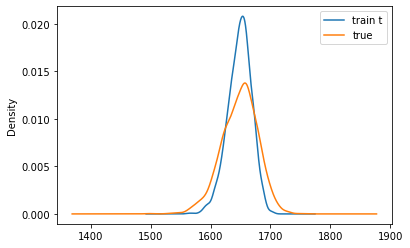


 Распределения истинных и предсказанных данных T на тесте


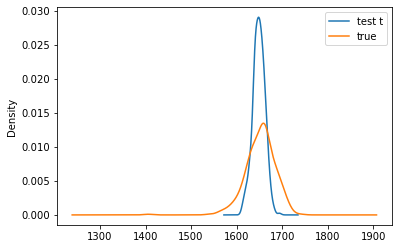


 Распределения истинных и предсказанных данных C на трейне


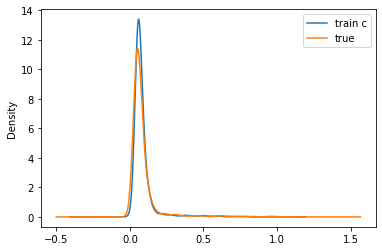


 Распределения истинных и предсказанных данных C на тесте


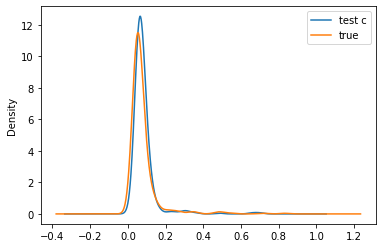

In [507]:
X_train, X_valid = train_test_split(
    target_train_1.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train_1['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train_1['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [472]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

413

In [480]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [510]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [508]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers

,TST,C
1944,1684,0.037
56,1666,0.056
622,1698,0.065
555,1657,0.058
1770,1704,0.033
...,...,...
750,1617,0.059
508,1658,0.058
697,1611,0.045
1357,1687,0.114


In [509]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions

,TST,C
1944,1684,0.037
56,1666,0.056
622,1698,0.065
555,1657,0.058
1770,1704,0.033
...,...,...
750,1617,0.059
508,1658,0.058
697,1611,0.045
1357,1687,0.114


In [481]:
len(test_t), len(test_c)

(780, 780)

In [482]:
test['NPLV']

0      512324
1      512327
2      512328
3      512331
4      512333
        ...  
775    513369
776    513370
777    513371
778    513372
779    513374
Name: NPLV, Length: 780, dtype: int64

In [495]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit

,NPLV,TST,C
0,512324,1636.861713,0.086299
1,512327,1634.809976,0.098023
2,512328,1652.988584,0.038351
3,512331,1635.193999,0.104375
4,512333,1636.713489,0.089071
...,...,...,...
775,513369,1650.904408,0.434585
776,513370,1648.267841,0.465345
777,513371,1644.120040,0.216766
778,513372,1656.315264,0.356402


In [499]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-30_04-46-41.csv

 File saved to disk!


# Baseline 2

Добавляем chronom

In [591]:
target_train.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_К', 'VES_8_О', 'VES_13_КП',
       'VES_23_ЛЧ', 'VES_61_КШС8', 'VES_20_ОК', 'VES_48_У2КШ', 'VES_49_25КШ',
       'VES_63_СК', 'VES_3_НБ', 'O2_Выпуск металла', 'O2_Додувка на C',
       'O2_Додувка на t', 'O2_Завалка лома', 'O2_Заливка чугуна',
       'O2_Нагрев лома', 'O2_Отсечка шлака', 'O2_Охл. азотом', 'O2_Повалка',
       'O2_Прерыв. выпуска', 'O2_Продувка', 'O2_Скач. шлака', 'O2_Слив шлака',
       'durat_Выпуск металла', 'durat_Додувка на C', 'durat_Додувка на t',
       'durat_Завалка лома', 'durat_Заливка чугуна', 'durat_Нагрев лома',
       'durat_Отсечка шлака', 'durat_Охл. азотом', 'durat_Повалка',
       'durat_Прерыв. выпуска', 'durat_Продувка', 'durat_Скач. шлака',
       'durat_Слив шлака'],
      dtype='object')

In [592]:
target_train_1 = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
target_train_1.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_', 'VES_8_', 'VES_13_', 'VES_23_',
       'VES_61_8', 'VES_20_', 'VES_48_2', 'VES_49_25', 'VES_63_', 'VES_3_',
       'O2_', 'O2_C', 'O2_t', 'O2_', 'O2_', 'O2_', 'O2_', 'O2_', 'O2_', 'O2_',
       'O2_', 'O2_', 'O2_', 'durat_', 'durat_C', 'durat_t', 'durat_', 'durat_',
       'durat_', 'durat_', 'durat_', 'durat_', 'durat_', 'durat_', 'durat_',
       'durat_'],
      dtype='object')

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 15.3282	train's l2: 234.952	test T's rmse: 23.8	test T's l2: 566.441
[50]	train's rmse: 11.6577	train's l2: 135.902	test T's rmse: 23.4572	test T's l2: 550.238
[75]	train's rmse: 9.28032	train's l2: 86.1244	test T's rmse: 23.4503	test T's l2: 549.916
[100]	train's rmse: 7.49292	train's l2: 56.1439	test T's rmse: 23.4667	test T's l2: 550.687
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 7.49292	train's l2: 56.1439	test T's rmse: 23.4667	test T's l2: 550.687
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0536505	train's l2: 0.00287838	test C's rmse: 0.0576571	test C's l2: 0.00332434
[50]	train's rmse: 0.042047	train's l2: 0.00176795	test C's rmse: 0.0589483	test C's l2: 0.0034749
[75]	train's rmse: 0.0349221	train's l2: 0.00121955	test C's rmse: 0.0596562	test C's l2: 0.00355886
[100]	train's rmse: 0.0295007	train's l2: 0.00087029	test C's rmse: 0.0

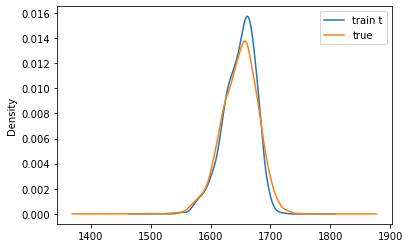


 Распределения истинных и предсказанных данных T на тесте


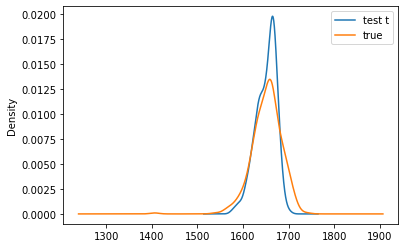


 Распределения истинных и предсказанных данных C на трейне


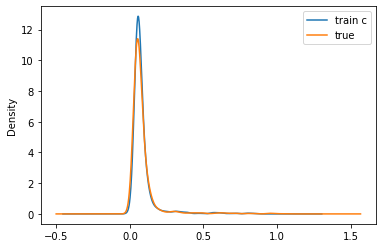


 Распределения истинных и предсказанных данных C на тесте


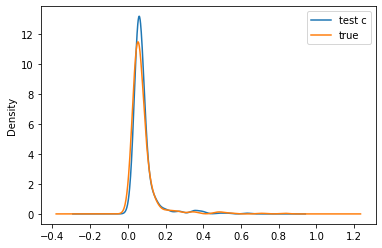

In [593]:
X_train, X_valid = train_test_split(
    target_train_1.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train_1['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train_1['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [594]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

In [595]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [598]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [599]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [600]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [601]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit.head(2# Baseline 2

Добавляем chronom

target_train.columns)

,NPLV,TST,C
0,512324,1658.450485,0.057486
1,512327,1656.708173,0.047649


# Baseline 3

Добавляем plavki

In [804]:
target_train.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR',
       ...
       'plavka_NAPR_ZAD_', 'plavka_TIPE_FUR_', 'plavka_TIPE_FUR_',
       'plavka_TIPE_GOL_4x54', 'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_5',
       'plavka_TIPE_GOL_6015', 'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_32',
       'plavka_TIPE_GOL_37454'],
      dtype='object', length=144)

In [805]:
target_train_1 = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
target_train_1.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR',
       ...
       'plavka_NAPR_ZAD_', 'plavka_TIPE_FUR_', 'plavka_TIPE_FUR_',
       'plavka_TIPE_GOL_4x54', 'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_5',
       'plavka_TIPE_GOL_6015', 'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_32',
       'plavka_TIPE_GOL_37454'],
      dtype='object', length=144)

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 14.4959	train's l2: 210.131	test T's rmse: 23.1266	test T's l2: 534.839
[50]	train's rmse: 10.7582	train's l2: 115.739	test T's rmse: 22.8357	test T's l2: 521.467
[75]	train's rmse: 8.37188	train's l2: 70.0883	test T's rmse: 22.773	test T's l2: 518.61
[100]	train's rmse: 6.66281	train's l2: 44.393	test T's rmse: 22.6794	test T's l2: 514.355
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 6.66281	train's l2: 44.393	test T's rmse: 22.6794	test T's l2: 514.355
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0542188	train's l2: 0.00293968	test C's rmse: 0.0549076	test C's l2: 0.00301484
[50]	train's rmse: 0.0419954	train's l2: 0.00176362	test C's rmse: 0.0538643	test C's l2: 0.00290136
[75]	train's rmse: 0.0340903	train's l2: 0.00116215	test C's rmse: 0.0557399	test C's l2: 0.00310694
[100]	train's rmse: 0.0286752	train's l2: 0.000822264	test C's rmse: 0

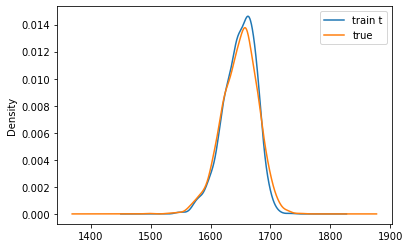


 Распределения истинных и предсказанных данных T на тесте


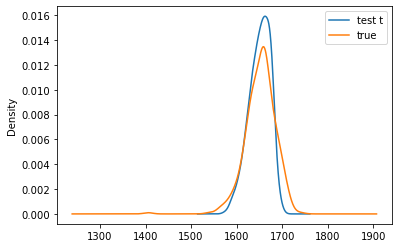


 Распределения истинных и предсказанных данных C на трейне


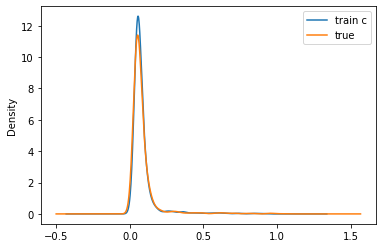


 Распределения истинных и предсказанных данных C на тесте


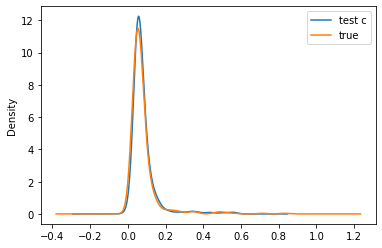

In [806]:
X_train, X_valid = train_test_split(
    target_train_1.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train_1['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train_1['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [807]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

In [808]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [809]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [810]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [811]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [812]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit.head(2)

,NPLV,TST,C
0,512324,1654.439394,0.068279
1,512327,1655.975199,0.058657


In [813]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-30_15-29-16.csv

 File saved to disk!


# Baseline 4

Добавляем produv

In [1071]:
target_train.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR',
       ...
       'plavka_TIPE_FUR_', 'plavka_TIPE_FUR_', 'plavka_TIPE_GOL_4x54',
       'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_5', 'plavka_TIPE_GOL_6015',
       'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_32', 'plavka_TIPE_GOL_37454',
       'pol_ras_sum'],
      dtype='object', length=145)

In [1072]:
target_train_1 = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
target_train_1.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR',
       ...
       'plavka_TIPE_FUR_', 'plavka_TIPE_FUR_', 'plavka_TIPE_GOL_4x54',
       'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_5', 'plavka_TIPE_GOL_6015',
       'plavka_TIPE_GOL_454', 'plavka_TIPE_GOL_32', 'plavka_TIPE_GOL_37454',
       'pol_ras_sum'],
      dtype='object', length=145)

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 14.4279	train's l2: 208.164	test T's rmse: 23.3143	test T's l2: 543.555
[50]	train's rmse: 10.6786	train's l2: 114.033	test T's rmse: 22.9779	test T's l2: 527.984
[75]	train's rmse: 8.24427	train's l2: 67.968	test T's rmse: 22.9208	test T's l2: 525.365
[100]	train's rmse: 6.58623	train's l2: 43.3785	test T's rmse: 22.8306	test T's l2: 521.238
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 6.58623	train's l2: 43.3785	test T's rmse: 22.8306	test T's l2: 521.238
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0537915	train's l2: 0.00289353	test C's rmse: 0.0553439	test C's l2: 0.00306295
[50]	train's rmse: 0.0419766	train's l2: 0.00176203	test C's rmse: 0.0563988	test C's l2: 0.00318082
[75]	train's rmse: 0.0339693	train's l2: 0.00115391	test C's rmse: 0.0566352	test C's l2: 0.00320754
[100]	train's rmse: 0.0279473	train's l2: 0.000781052	test C's rmse

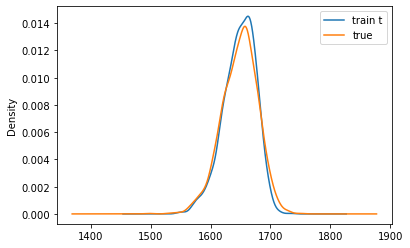


 Распределения истинных и предсказанных данных T на тесте


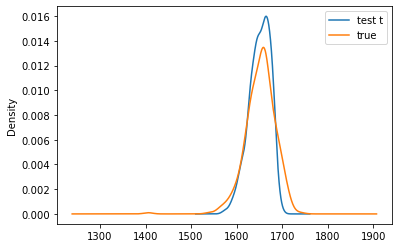


 Распределения истинных и предсказанных данных C на трейне


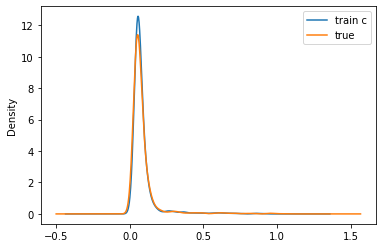


 Распределения истинных и предсказанных данных C на тесте


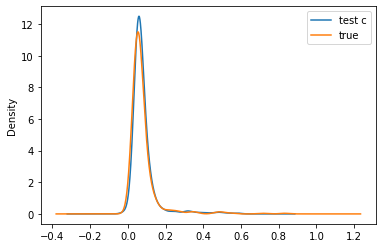

In [1073]:
X_train, X_valid = train_test_split(
    target_train_1.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train_1['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train_1['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [1074]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

In [1075]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [1076]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [1077]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [1078]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [1079]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit.head(2)

,NPLV,TST,C
0,512324,1652.526945,0.062893
1,512327,1660.170507,0.061310


In [1080]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-30_18-14-27.csv

 File saved to disk!


# Baseline 5

Добавляем gas

In [1087]:
target_train.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T_x', 'SI', 'MN', 'S', 'P', 'CR',
       ...
       'CO', 'CO2', 'H2', 'N2', 'O2', 'O2_pressure', 'T_y', 'T фурмы 1',
       'T фурмы 2', 'V_y'],
      dtype='object', length=156)

In [1088]:
target_train_1 = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
target_train_1.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T_x', 'SI', 'MN', 'S', 'P', 'CR',
       ...
       'CO', 'CO2', 'H2', 'N2', 'O2', 'O2_pressure', 'T_y', 'T1', 'T2', 'V_y'],
      dtype='object', length=156)

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 13.9734	train's l2: 195.257	test T's rmse: 23.2789	test T's l2: 541.909
[50]	train's rmse: 9.88162	train's l2: 97.6465	test T's rmse: 22.7155	test T's l2: 515.995
[75]	train's rmse: 7.4522	train's l2: 55.5353	test T's rmse: 22.6241	test T's l2: 511.849
[100]	train's rmse: 5.74399	train's l2: 32.9935	test T's rmse: 22.6297	test T's l2: 512.104
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 5.74399	train's l2: 32.9935	test T's rmse: 22.6297	test T's l2: 512.104
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0515728	train's l2: 0.00265976	test C's rmse: 0.0558892	test C's l2: 0.00312361
[50]	train's rmse: 0.0377156	train's l2: 0.00142246	test C's rmse: 0.054753	test C's l2: 0.00299789
[75]	train's rmse: 0.0301899	train's l2: 0.000911428	test C's rmse: 0.0556131	test C's l2: 0.00309281
[100]	train's rmse: 0.0244386	train's l2: 0.000597247	test C's rmse

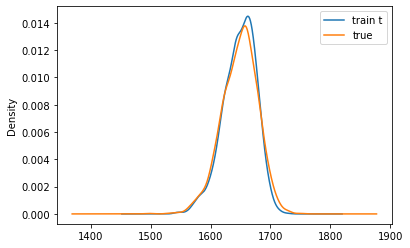


 Распределения истинных и предсказанных данных T на тесте


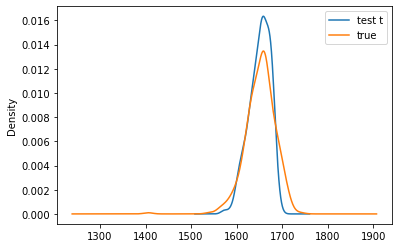


 Распределения истинных и предсказанных данных C на трейне


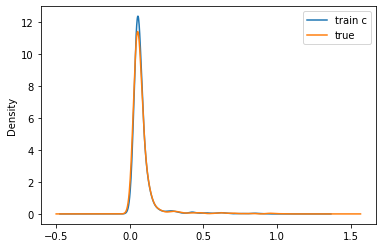


 Распределения истинных и предсказанных данных C на тесте


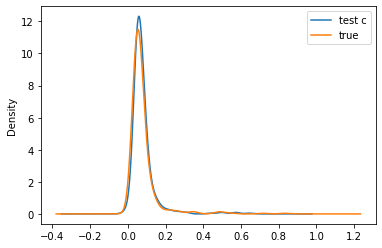

In [1089]:
X_train, X_valid = train_test_split(
    target_train_1.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train_1['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train_1['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [1090]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

In [1091]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [1092]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [1093]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [1094]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [1095]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit.head(2)

,NPLV,TST,C
0,512324,1655.645573,0.068784
1,512327,1670.682501,0.073836


In [1096]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-30_19-03-46.csv

 File saved to disk!


# Результаты

Дата | Время | Скор на обучении | Скор на тесте | Скор на лидерборде | Модель| Датасет  | Место
-|-|-|-|-|-|-|-
30.10.2021 | 05:00 | 1? | 1? | 0.31153846153846154 |  | | 24
30.10.2021 | 13:48 | | | 0.5025641025641026 | base 2| добавил chronom | 17
30.10.2021 | 15:29 | | | 0.5064102564102564 | base 3 | добавил plavki | 20
30.10.2021 | 18:15 |	| | 0.5166666666666667 | base 4 | всё без gas, sip (добавил produv) | 23
30.10.2021 | 19:04 | | | 0.4846153846153846 | base 5 | всё без sip (добавил gas) | 
31.10.2021 | 00:21 | | | 0.5012820512820513 | lama wo gas | всё без gas и без sip | 
31.10.2021 | 00:39 | | | 0.41923076923076924 | lgbm kagle params | всё без gas и без sip| 
31.10.2021 | 00:43 | | | **0.49615384615384617** | **3_model.ipynb**: lgbm st params | всё без gas и без sip| 
31.10.2021 | 00:46 | | | **0.48717948717948717** | 2_lama_gas | всё без sip (добавил gas) | 
31.10.2021 | 05:05 | | | 0.48205128205128206 | xgb outlier=None | всё без gas и без sip | 		
31.10.2021 | 05:08 | | | 0.48205128205128206 | xgb outlier=100 | всё без gas и без sip | 
31.10.2021 | 05:57 | | | 0.5166666666666667 | xgb n_trees=15 | всё без gas и без sip | 		
31.10.2021 | 06:07 | | | 0.5115384615384615 | xgb n_trees=16 | всё без sip (добавил gas) | 